In [7]:
#physical constant

#physical constant
clight=299792458   
cc=clight # m/s
me0=9.107e-31 # mass of electron kg
eps0=8.854e-12   # permitivity of free-space
mu0=4*pi*1e-7  # H/m

qe=1.602e-19 #C
Bzk=1.380e-23 # Boltzmann's constant j/K
Pkh=6.626e-34  # Planck's constant  J-sec
re0=qe^2/(me0*clight^2)  # classical radius of electron
Cgamma=4*pi/3*re0/(me0*clight^2)^3*(qe*10^9)^3  # m/GeV^3  This is sychrotron radiation constant

using PyPlot
#using Distributions
using Dates
using ControlSystems
using FFTW
using JLD
using LsqFit
using DelimitedFiles
using DataFrames
#using DSP
using XLSX
#using NLsolve
using Roots
#using PolynomialZeros

donetime=Dates.format(now(), "dd-HH:MM:SS")
starttime=DateTime(now())
Dates.value(starttime)
usec=1e-6;MHz=1e6;kW=1000;MW=1e6;mA=0.001;MV=1e6;deg=1;rad=1;Hz=1;kHz=1000

1000

In [8]:
# RF parameter
f0=563e6 #563 MHz
omega0=2*pi*f0
lambda0=clight/f0  #m

epsr=1
#Geometry parameters
Rinner=14.32e-3 #m
Z0=75 #ohm
Router=Rinner*exp(Z0*sqrt(epsr)/60)
Zx=60/sqrt(epsr)*log(Router/Rinner)
Linner=50e-2+lambda0/2 # m
Area(R,L)=2*pi*R*L  # the area of the surface of the inner conductor 



sigma_OFC=5.8e7 # mho/m
delta_s(omega,sigma)=sqrt(2/omega/mu0/sigma)
RsO(omega,sigma)=1/delta_s(omega,sigma)/sigma
eta0=sqrt(mu0/eps0)
#print (lambda)


376.73430918211017

In [9]:
# The cut off frequency of the first higher order mode of the coaxial line
lambdaC_TE11(Ro,Rin)=pi*(Ro+Rin)
clight/lambdaC_TE11(Router,Rinner)

1.484049202996554e9

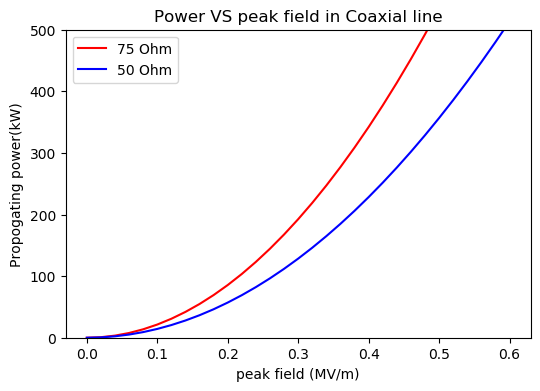

peak field of 75 Ohm is 0.48361974459570634 peak field of 50 Ohm is 0.3906358450846085
Attenuation ratio (50/75) is 1.6702936767140084
Breakdown field ratio(50/75)is:0.8077334506083287

In [10]:
# The coaxial line attenatation is 
alpha_c(omega,sigma,Ro,Rin)=RsO(omega,sigma)/(2*Ro)*(1+Rin/Ro)/(eta0*log(Ro/Rin))

# The power vs peak field
Power(E0,Ro,Rin)=pi*(E0*Rin)^2*log(Ro/Rin)/sqrt(mu0/eps0/epsr)
Epeak(P0,Ro,Rin)=sqrt(P0/(log(Ro/Rin)/sqrt(mu0/eps0/epsr))/pi)/Rin
Power_bd(E0,Ro,Rin)=pi*(E0*Rin)^2*log(Ro/Rin)/sqrt(mu0/eps0/epsr)
E_bd(P0,Ro,Rin)=sqrt(P0/(log(Ro/Rin)/sqrt(mu0/eps0/epsr))/pi)/Rin
E=0:0.02:0.6
fig=figure(figsize=(6,4))
plot(E,map(E->Power(E*1e6,Router,Rinner)/1000,E),"r-",Label="75 Ohm")

plot(E,map(E->Power(E*1e6,Rinner*2.303,Rinner)/1000,E),"b-",Label="50 Ohm")
ylim(0,500)
title("Power VS peak field in Coaxial line")
xlabel("peak field (MV/m)")
ylabel("Propogating power(kW)")
legend(loc="upper left",fancybox="true")

print("peak field of 75 Ohm is ",Epeak(500e3,Router,Router/3.49)/1e6," peak field of 50 Ohm is ", Epeak(500e3,Router,Router/2.303)/1e6,"\n")
print("Attenuation ratio (50/75) is ",alpha_c(omega0,sigma_OFC,Router,Router/2.303)/alpha_c(omega0,sigma_OFC,Router,Router/3.49),"\n","Breakdown field ratio(50/75)is:",E_bd(1e5,Router,Router/2.303)/E_bd(1e5,Router,Router/3.49))

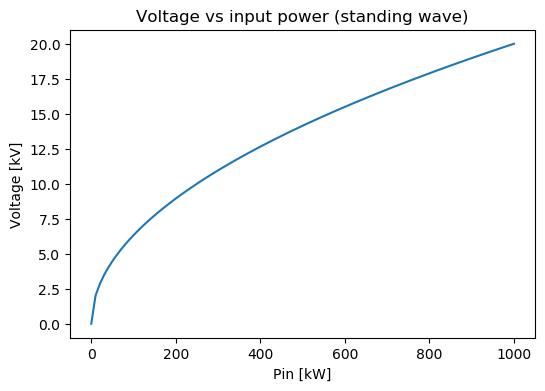

PyObject Text(0.5, 1, 'Voltage vs input power (standing wave)')

In [11]:
Vm(P,Z0)=sqrt(P*2*Z0)*1e-3*2
P=0:1e1:1e3
fig=figure(figsize=(6,4))
plot(P,map(P->Vm(P*1e3,50),P))
xlabel("Pin [kW]")
ylabel("Voltage [kV]")
title("Voltage vs input power (standing wave)")

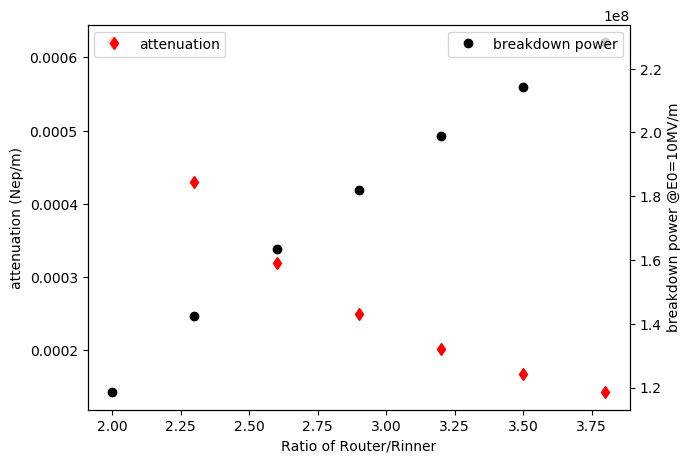

PyObject <matplotlib.legend.Legend object at 0x7fb3ee3cfa50>

In [12]:
Rox=2:0.3:4;
fig=figure(figsize=(7,5))
ax=gca()
plot(Rox,map(r->alpha_c(omega0,sigma_OFC,r*Rinner,Rinner),Rox),"rd",Label="attenuation")
xlabel("Ratio of Router/Rinner")
ylabel("attenuation (Nep/m)")
legend(loc="upper left",fancybox="true")
ax2 = ax[:twinx]()
plot(Rox,map(r->Power_bd(10e6,r*Rinner,Rinner),Rox),"ko",Label="breakdown power")
ylabel("breakdown power @E0=10MV/m")
legend(loc="upper right",fancybox="true")

In [13]:
# Power transmission and Dissipation
Pout(Pin,z,ratio,Ro)=Pin*exp(-2*alpha_c(omega0,sigma_OFC,Ro,Ro/ratio)*z)
Pdinner(Pin,z,ratio,Ro)=Pin*(1-exp(-2*alpha_c(omega0,sigma_OFC,Ro,Ro/ratio)*z))*1/(Ro/ratio)/(1/(Ro/ratio)+1/Ro)
Pdouter(Pin,z,ratio,Ro)=Pin*(1-exp(-2*alpha_c(omega0,sigma_OFC,Ro,Ro/ratio)*z))*1/Ro/(1/(Ro/ratio)+1/Router)
Pinput=5e5 #kW
print(Pinput-Pout(Pinput,Linner,3.49,Router),"  ",Pdinner(Pinput,Linner,3.49,Router),"  ",Pdouter(Pinput,Linner,3.49,Router))

print("\n",Pinput-Pout(Pinput,Linner,2.303,Router),"  ", Pdinner(Pinput,Linner,2.303,Router),"  ",Pdouter(Pinput,Linner,2.303,Router))



129.62849208404077  100.75800386932629  28.87048821470667
216.49883707729168  150.9527162546277  65.5461208226781

In [8]:
print("attenuation ratio (50/75) is ",alpha_c(omega0,sigma_OFC,Router,Router/2.303)/alpha_c(omega0,sigma_OFC,Router,Router/3.49),"%0.3","\n","Breakdown field ratio(50/70)is:",E_bd(1e5,Router,Router/2.303)/E_bd(1e5,Router,Router/3.49))

attenuation ratio (50/75) is 1.6702936767140084%0.3
Breakdown field ratio(50/70)is:0.8077334506083287

# Stub tunners

In [14]:
Kc_TE10=sqrt(pi/(15*2.54*0.01)^2+(0*pi/15*2.54*0.01/2)^2)
K_rf=(2pi*704e6/clight)
beta_TE10=sqrt(K_rf^2-Kc_TE10^2)
#1/1.837998127801519*clight/563e6*beta_TE10/pi
2pi/beta_TE10


0.44872971101934117

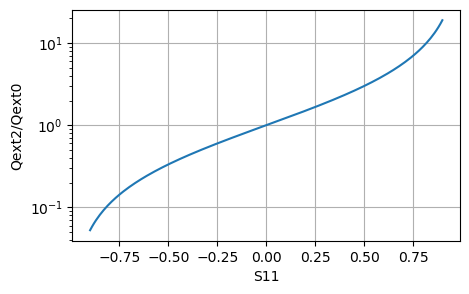

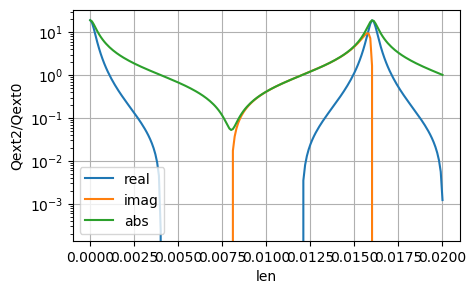

PyObject Text(0.5, 1, '')

In [20]:
f0=704e6;w0=2pi*f0

function Qext_tuner(Qext0,S11,len,f)
    sp=(1+S11)/(1-S11)
    tranLine=tan(beta_TE10*len)
    Q_ratio=(sp-1im*tranLine)/(1+1im*sp*tranLine)
    
    A=sp*(1+tranLine)/(1+(sp*tranLine)^2)
    B=tranLine*(-4*S11/(1-S11)^2)/(1+(sp*tranLine)^2)
    Q0=1e9; 
    R0=100*1e9
    Rload_new=R0/(1+Q0/(Qext0*Q_ratio))
    Z_top=Rload_new
    Z_bot=1-1im*A*Qext0*(f0/f-f/f0)+B*Qext0*(f0/f-f/f0)
    Ztot_new=Z_top/Z_bot
    Z_orig=R0/(1-1im*Qext0*(f0/f-f/f0))
    Q_ratio2 =sp
    return Q_ratio,  Ztot_new, Z_orig
end

S11=-0.9:0.01:0.9    
# Qr=Qext_tuner(1,S11,1/1.837998127801519*clight/563e6)
fig=figure(figsize=(5,3))
plot(S11,map(S11->abs(Qext_tuner(1,S11,pi*0,100)[1]),S11))
ylabel("Qext2/Qext0")
yscale("log")
xlabel("S11")
grid("on")
title("")

len=0:0.0001:0.02
fig=figure(figsize=(5,3))
plot(len,map(len->real(Qext_tuner(1,0.9,beta_TE10.*len,100)[1]),len),label="real")
plot(len,map(len->imag(Qext_tuner(1,0.9,beta_TE10.*len,100)[1]),len),label="imag")
plot(len,map(len->abs(Qext_tuner(1,0.9,beta_TE10.*len,100)[1]),len),label="abs")
legend()
ylabel("Qext2/Qext0")
yscale("log")
xlabel("len")
grid("on")
title("")


In [16]:
f=703.8e6:1e3:704.2e6
beta_len0=pi+0.01
Qext0=1e5;S11=-0.51-1im*0.0
function plot_ZQ(f,beta_len0,Qext0,S11)
fig=figure(figsize=(6,3))
title("betaL=0.1,S11=0")
Znew_norm=maximum(map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f))
Zorig_norm=maximum(map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[3]),f))
    
plot1=plot(f,map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f)/Znew_norm,label="Znew_real")
#fig=figure(figsize=(6,3))
plot2=plot(f,map(f->imag(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f)/Znew_norm,label="Znew_imag")
legend()
grid("on")
#fig=figure(figsize=(6,3))
plot(f,map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[3]),f)/Zorig_norm,label="Zorig_real")

plot(f,map(f->imag(Qext_tuner(Qext0,S11,beta_len0,f)[3]),f)/Zorig_norm,label="Zorig_real")
xlabel("freq")
legend()
fig=figure(figsize=(6,3))
plot(f,map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f)/Znew_norm,label="Qext_new_real")
#plot(f,map(f->abs(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f)/Znew_norm,label="Qext_new_abs")
plot(f,map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[3]),f)/Zorig_norm,label="Qext_orig")
legend()
ylabel("Z(f)")
yscale("log")
xlabel("freq")
grid("on")
title("betaL=0.1,S11=0.")


fig=figure(figsize=(4,3))
title("betaL=0.1,S11=0.") 
plot(map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f)/Znew_norm,1/Znew_norm*map(f->imag(Qext_tuner(Qext0,S11,beta_len0,f)[2]),f),label="Znew")
legend()
#fig=figure(figsize=(5,3))
plot(map(f->real(Qext_tuner(Qext0,S11,beta_len0,f)[3]),f)/Zorig_norm,1/Zorig_norm*map(f->imag(Qext_tuner(Qext0,S11,beta_len0,f)[3]),f),label="Zorig")
legend()
xlabel("real")
ylabel("imag")
grid("on")

end
#plot_ZQ(f,beta_len0,Qext0,S11)

plot_ZQ (generic function with 1 method)

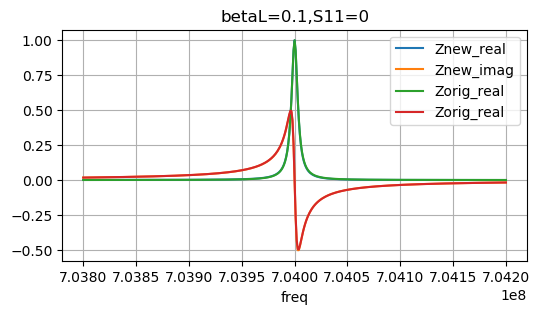

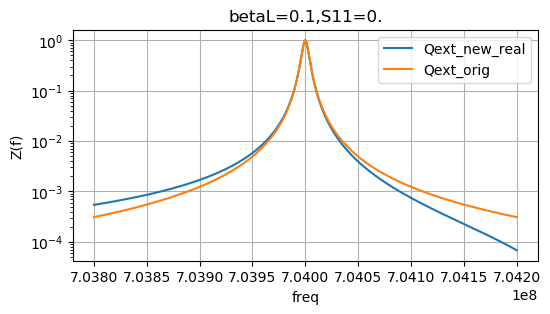

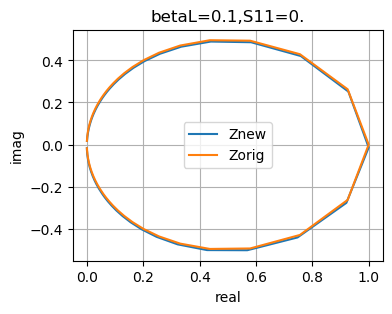

In [17]:
f=703.8e6:1e3:704.2e6
beta_len0=pi+0.0
Qext0=1e5;S11=-0
plot_ZQ(f,beta_len0,Qext0,S11)

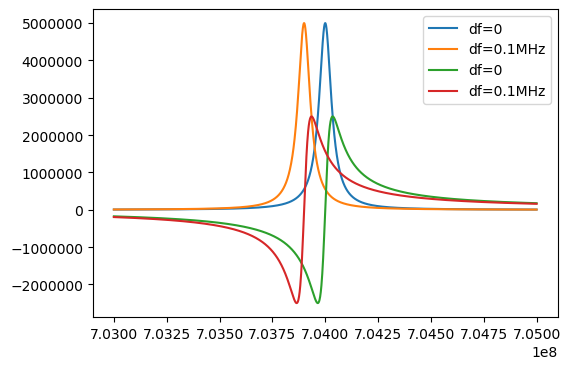

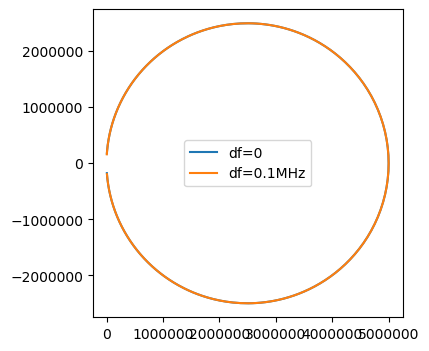

PyObject <matplotlib.legend.Legend object at 0x7fb3f131cf10>

In [18]:
# Single mode Impedance and wake
Q0=1e10;Qload=Q0/(1+1e6);f0=704e6;frf=f0;RoQ=500
function Zcavity(f,df)
    Qext=1/(1/Qload-1/Q0)
    fcavity=frf-df
    Z=Qload*RoQ/(1+(Qload*(fcavity/f-f/fcavity))*1im)
    return Z
end
f=703.e6:1e3:705e6
fig=figure(figsize=(6,4))
plot(f,map(f->Zcavity(f,0),f),label="df=0")
plot(f,map(f->Zcavity(f,1e5),f),label="df=0.1MHz")
plot(f,imag(map(f->Zcavity(f,0),f)),label="df=0")
plot(f,imag(map(f->Zcavity(f,1e5),f)),label="df=0.1MHz")
legend()
fig=figure(figsize=(4,4))
plot(real(map(f->Zcavity(f,0),f)),imag(map(f->Zcavity(f,0),f)),label="df=0")
plot(real(map(f->Zcavity(f,1e5),f)),imag(map(f->Zcavity(f,1e5),f)),label="df=0.1MHz")

legend()


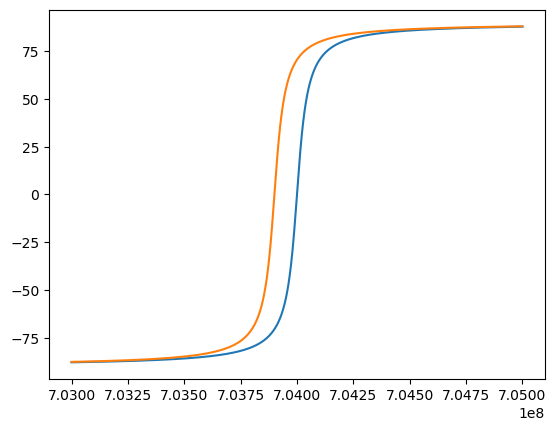

70.60918812718764

In [19]:
f=703.e6:1e3:705e6
plot(f,180/pi*atan.(imag(map(f->Zcavity(f,0),f))./real(map(f->Zcavity(f,0),f))),label="df=0")
plot(f,180/pi*atan.(imag(map(f->Zcavity(f,0.1e6),f))./real(map(f->Zcavity(f,0.1e6),f))),label="df=0.1MHz")
180/pi*angle(Zcavity(704e6,0.1e6))

# waveguide-transmission

In [15]:

# Tuner 1 parameters
ref_coeTuner1(ref1,phs)=ref1*exp(1im*phs); # forward wave reflection at port1, forward: source to shhorting plate
Tran_coeTuner1(ref1,phs)=1+ref_coeTuner1(ref1,phs)  # forward wave transmission at port 1

ref1_coeTuner1(ref1,phs)=-ref1*exp(1im*phs); # reflection wave reflection at port1, forward: source to shhorting plate
Tran1_coeTuner1(ref1,phs)=1+ref1_coeTuner1(ref1,phs)  # reflection wave transmission at port 1




angle(ref_coeTuner1(1,30*pi/180))*180/pi

29.999999999999993

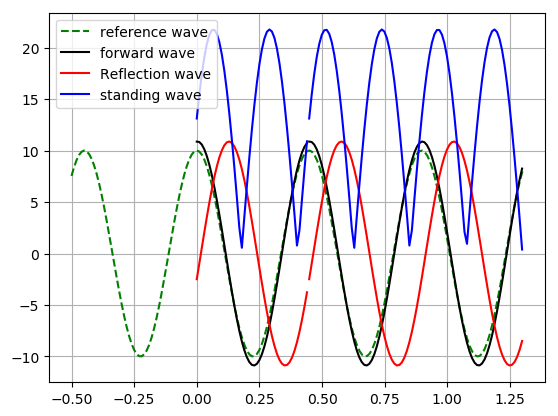

PyObject <matplotlib.legend.Legend object at 0x0000000062148A20>

In [16]:
#shortting plate  and phase shifter parameter
delta_ps=0*pi/180
ref_coef_shorting(ref_sp,phs_sp)=ref_sp*exp(1im*phs_sp)

A0=10;zlload=1.30;zltunner=0.0;zlps=2pi/beta_TE10; ref0=0.1;phs0=30*pi/180;ref_sp0=1;phs_sp0=pi
###step 1
Vfor_source(zl)=A0*exp(-1im*beta_TE10*zl)  # forward
Vfor_tran1(zl)=Vfor_source(zl)*(1+ref_coeTuner1(ref0,phs0))  # forward
Vfor_ref1(zl)=Vfor_source(zl)*(ref_coeTuner1(ref0,phs0))  # reflection
zln0=-0.5:0.01:zltunner
zln=zltunner:0.01:zlps
zt=-0.5:0.01:zlload
plot(zt,map(zl->real(Vfor_source(zl)),zt),"g--",label="reference wave")
#plot(zln0,map(zl->real(Vfor_ref1(zl)),zln0),"r--")
plot(zln,map(zl->real(Vfor_tran1(zl)),zln),"k")
zln2=zlps:0.01:zlload
Vfor_tran2(zl)=Vfor_tran1(zl)*exp(1im*delta_ps)  # forward
plot(zln2,map(zl->real(Vfor_tran2(zl)),zln2),"k",label="forward wave")

### step#2
# between shorting plate and phase shifter
Vref_load(zl)=Vfor_tran2(zlload)*ref_coef_shorting(ref_sp0,phs_sp0)*exp(-1im*beta_TE10*(zlload-zl))
plot(zln2,map(zl->real(Vref_load(zl)),zln2),"r-")
Vref_load2(zl)=Vref_load(zl)*exp(1im*delta_ps)  # backforward wave between phase shifter and tuner
plot(zln,map(zl->real(Vref_load2(zl)),zln),"r-",label="Reflection wave")
# reflected wave, reflected back to become forward
Vref_load3(zl)=Vref_load2(zltunner)*ref1_coeTuner1(ref0,phs0)
Vref_load32(zl)=Vref_load3(zl)*exp(1im*delta_ps)   # between phase shifter and shorting plate
#reflection from the shortplate, between shorting plate and phase shifter
Vref_short3(zl)=Vfor_tran2(zlload)*ref_coef_shorting(ref_sp0,phs_sp0)*exp(-1im*beta_TE10*(zlload-zl))  
Vref_short4(zl)=Vref_short3(zl)*exp(1im*delta_ps)   # backforward wave between phase shifter and tuner


grid()
# between phase shifter and shorting plate
Vtot_load(zl)=Vfor_tran2(zl)+Vref_load(zl)#+Vref_load32(zl)+Vref_short3(zl)

Vtot_load2(zl)=Vfor_tran1(zl)+Vref_load2(zl)#+Vref_load3(zl)+Vref_short4(zl)

plot(zln2,map(zl->abs(Vtot_load(zl)),zln2),"b-",label="standing wave")
plot(zln,map(zl->abs(Vtot_load2(zl)),zln),"b-")
legend()


In [17]:
Q0=2e10;RoQ=146;Z0=50;Lcav=0.5352;deltaf=5e2;Qload=3e5  #2.5e4;
fres=frf-deltaf #predetune in Hz
rho=RoQ/2; # (rho is the half of Rshunt/Qo, i.e circuit definition)
Rsh=Q0*RoQ;R=Rsh/2;wo=2*pi*fres;Tfill=2*Qload/wo;w12=wo/(2Qload);Rload=rho*Qload; #( Rload is circuit definition)
#n_coupler=sqrt(R/Z0*Qload/(Q0-Qload));
beta_coupler=Q0/Qload-1;n_coupler=sqrt(R/beta_coupler/Z0);tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)

Vcav=2e6; Ib=0.025830

Vfor_wg1(f)=0.5*sqrt(Z0/beta_coupler/R)*(beta_coupler+1-1im*Q0*(fres/f-f/fres))*Vcav+n_coupler*Z0*Ib
Vref_wg1(f)=0.5*sqrt(Z0/beta_coupler/R)*(beta_coupler-1+1im*Q0*(fres/f-f/fres))*Vcav-n_coupler*Z0*Ib
Ref_cav(f)=Vref_wg1(f)/Vfor_wg1(f)
Ref_cav(fres)

0.2773835216331339 + 0.0im

In [18]:
Pc=Vcav*Vcav/2/R
Pb=(beta_coupler-1)*Pc
Ib=Pb/Vcav


0.04566073059360731

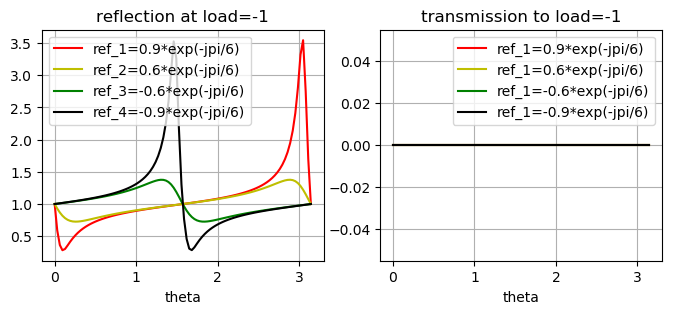

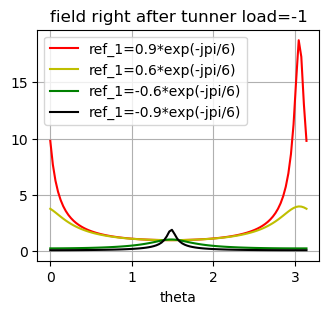

PyObject <matplotlib.legend.Legend object at 0x000000005E768D68>

In [19]:
ref_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=ref_coe1+(1+ref_coe1)*(1+ref_coe2)*ref_coe3*exp(-1im*2*theta)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))
Tran_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=(1+ref_coe3)*(1+ref_coe1)*exp(-1im*theta)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))
E_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=(1+ref_coe1)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))

fig=figure(figsize=(8,3))
thetaX=range(-0,length=100,stop=pi)

ref_coe3X=-1;ref1_abs=0.9;ref1_phase=10pi/180

ref_1=ref1_abs*exp(-1im*ref1_phase);ref_2=0.6*exp(-1im*ref1_phase);
ref_3=-0.6*exp(-1im*ref1_phase);ref_4=-0.9*exp(-1im*ref1_phase)

a1_09=map(thetaX->ref_coe_tot(ref_1,-ref_1,ref_coe3X,thetaX),thetaX)
a1_08=map(thetaX->ref_coe_tot(ref_2,-ref_2,ref_coe3X,thetaX),thetaX)
a1_07=map(thetaX->ref_coe_tot(ref_3,-ref_3,ref_coe3X,thetaX),thetaX)
a1_06=map(thetaX->ref_coe_tot(ref_4,-ref_4,ref_coe3X,thetaX),thetaX)

subplot(121)
plot(thetaX,abs.(a1_09),"r",label="ref_1=0.9*exp(-jpi/6)")
plot(thetaX,abs.(a1_08),"y",label="ref_2=0.6*exp(-jpi/6)")
plot(thetaX,abs.(a1_07),"g",label="ref_3=-0.6*exp(-jpi/6)")
plot(thetaX,abs.(a1_06),"k",label="ref_4=-0.9*exp(-jpi/6)")
title("reflection at load=-1")
xlabel("theta")
ylabel("")
grid()
#yscale("log")
legend()



T1_09=map(thetaX->Tran_coe_tot(ref_1,-ref_1,ref_coe3X,thetaX),thetaX)
T1_08=map(thetaX->Tran_coe_tot(ref_2,-ref_2,ref_coe3X,thetaX),thetaX)
T1_07=map(thetaX->Tran_coe_tot(ref_3,-ref_3,ref_coe3X,thetaX),thetaX)
T1_06=map(thetaX->Tran_coe_tot(ref_4,-ref_4,ref_coe3X,thetaX),thetaX)

subplot(122)
plot(thetaX,abs.(T1_09),label="ref_1=0.9*exp(-jpi/6)","r")
plot(thetaX,abs.(T1_08),label="ref_1=0.6*exp(-jpi/6)","y")
plot(thetaX,abs.(T1_07),label="ref_1=-0.6*exp(-jpi/6)","g")
plot(thetaX,abs.(T1_06),label="ref_1=-0.9*exp(-jpi/6)","k")
title("transmission to load=-1")
xlabel("theta")
ylabel("")
grid()
#yscale("log")
legend()


fig=figure(figsize=(8,3))
E_09=map(thetaX->E_coe_tot(ref_1,-ref_1,ref_coe3X,thetaX),thetaX)
E_08=map(thetaX->E_coe_tot(ref_2,-ref_2,ref_coe3X,thetaX),thetaX)
E_07=map(thetaX->E_coe_tot(ref_3,-ref_3,ref_coe3X,thetaX),thetaX)
E_06=map(thetaX->E_coe_tot(ref_4,-ref_4,ref_coe3X,thetaX),thetaX)


subplot(121)
plot(thetaX,abs.(E_09),label="ref_1=0.9*exp(-jpi/6)","r")
plot(thetaX,abs.(E_08),label="ref_1=0.6*exp(-jpi/6)","y")
plot(thetaX,abs.(E_07),label="ref_1=-0.6*exp(-jpi/6)","g")
plot(thetaX,abs.(E_06),label="ref_1=-0.9*exp(-jpi/6)","k")
title("field right after tunner load=-1")
xlabel("theta")
ylabel("")
grid()
#yscale("log")
legend()


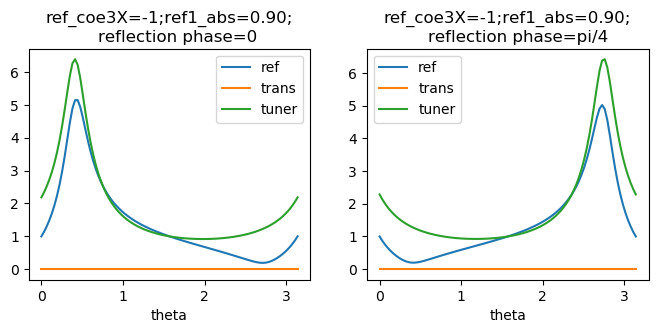

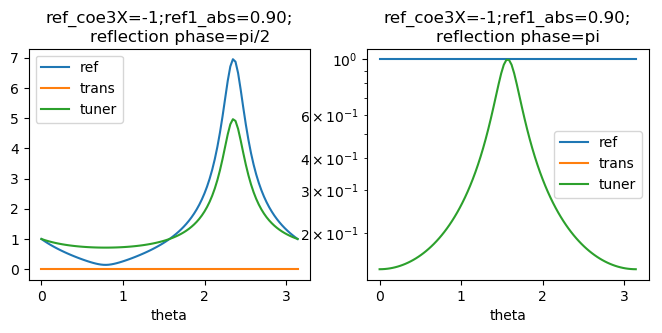

PyObject <matplotlib.legend.Legend object at 0x0000000060D76BA8>

In [20]:
### Note: ref1_coe2= - ref1_coe1, this is the case for pure impedance step
fig=figure(figsize=(8,3))

thetaX=range(-0,length=100,stop=pi)

ref_coe3X=-1;ref1_abs=0.7485977; Phase_shiftatTest=beta_TE10*(12+30+6)*25.4*1e-3

ref_1=ref1_abs*exp(-1im*(-5-42)*pi/180);ref_2=ref1_abs*exp(-1im*45pi/180);
ref_3=ref1_abs*exp(-1im*90pi/180);ref_4=ref1_abs*exp(-1im*180pi/180)

#reflection
a1_09=map(thetaX->ref_coe_tot(ref_1,-ref_1,ref_coe3X,thetaX),thetaX)
a1_08=map(thetaX->ref_coe_tot(ref_2,-ref_2,ref_coe3X,thetaX),thetaX)
a1_07=map(thetaX->ref_coe_tot(ref_3,-ref_3,ref_coe3X,thetaX),thetaX)
a1_06=map(thetaX->ref_coe_tot(ref_4,-ref_4,ref_coe3X,thetaX),thetaX)
# transmission
T1_09=map(thetaX->Tran_coe_tot(ref_1,-ref_1,ref_coe3X,thetaX),thetaX)
T1_08=map(thetaX->Tran_coe_tot(ref_2,-ref_2,ref_coe3X,thetaX),thetaX)
T1_07=map(thetaX->Tran_coe_tot(ref_3,-ref_3,ref_coe3X,thetaX),thetaX)
T1_06=map(thetaX->Tran_coe_tot(ref_4,-ref_4,ref_coe3X,thetaX),thetaX)
# tunner
E_09=map(thetaX->E_coe_tot(ref_1,-ref_1,ref_coe3X,thetaX),thetaX)
E_08=map(thetaX->E_coe_tot(ref_2,-ref_2,ref_coe3X,thetaX),thetaX)
E_07=map(thetaX->E_coe_tot(ref_3,-ref_3,ref_coe3X,thetaX),thetaX)
E_06=map(thetaX->E_coe_tot(ref_4,-ref_4,ref_coe3X,thetaX),thetaX)


fig=figure(figsize=(8,3))
subplot(121)
plot(thetaX,abs.(a1_09),label="ref");plot(thetaX,abs.(T1_09),label="trans");plot(thetaX,abs.(E_09),label="tuner")
title("ref_coe3X=-1;ref1_abs=0.90;
    reflection phase=0 ")
xlabel("theta")
#yscale("log")
legend()
subplot(122)
plot(thetaX,abs.(a1_08),label="ref");plot(thetaX,abs.(T1_08),label="trans");plot(thetaX,abs.(E_08),label="tuner")
title("ref_coe3X=-1;ref1_abs=0.90;
    reflection phase=pi/4")
xlabel("theta")
#yscale("log")
legend()
fig=figure(figsize=(8,3))
subplot(121)
plot(thetaX,abs.(a1_07),label="ref");plot(thetaX,abs.(T1_07),label="trans");plot(thetaX,abs.(E_07),label="tuner")
title("ref_coe3X=-1;ref1_abs=0.90;
    reflection phase=pi/2")
xlabel("theta")
#yscale("log")
legend()
subplot(122)
plot(thetaX,abs.(a1_06),label="ref");plot(thetaX,abs.(T1_06),label="trans");plot(thetaX,abs.(E_06),label="tuner")
title("ref_coe3X=-1;ref1_abs=0.90;
    reflection phase=pi")
xlabel("theta")
yscale("log")
legend()

#  Tuner design: Step #1 find the cavity reflection coefficency with various beam scenarios

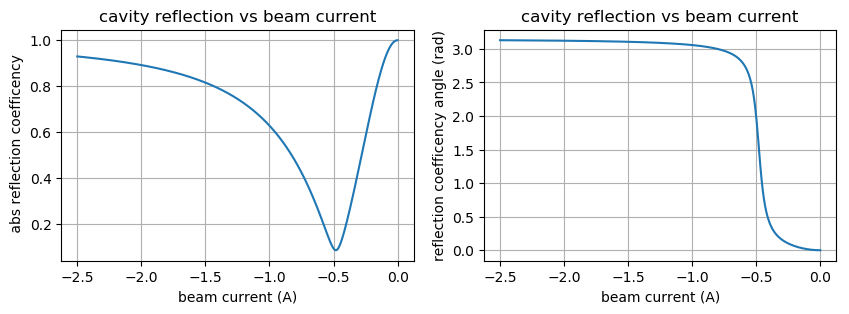

Ibx=-0.21227122712271226, Ref_cav_wg=0.6773153572329487 + 0.047515182294644555im voltage= -4.04e8

In [21]:
### Cavity 

Q0=2e10;RoQ=146;Z0=50;Lcav=0.5352;deltaf=5e2;Qload=3e5  #2.5e4;
fres=frf-deltaf #predetune in Hz
rho=RoQ/2; # (rho is the half of Rshunt/Qo, i.e circuit definition)
Rsh=Q0*RoQ;R=Rsh/2;wo=2*pi*fres;Tfill=2*Qload/wo;w12=wo/(2Qload);Rload=rho*Qload; #( Rload is circuit definition)
#n_coupler=sqrt(R/Z0*Qload/(Q0-Qload));
beta_coupler=Q0/Qload-1;n_coupler=sqrt(R/beta_coupler/Z0);tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)
##

Vfor_wg(wx,Pg,Ix,phs)=1/2*sqrt(Z0/beta_coupler/R)*(beta_coupler+1-1im*Q0*(wx/w0-w0/wx))*(Pg/Ix+1im*Pg/Ix*tan(phs))+Z0*n_coupler*Ix
Vref_wg(wx,Pg,Ix,phs)=1/2*sqrt(Z0/beta_coupler/R)*(beta_coupler-1+1im*Q0*(wx/w0-w0/wx))*(Pg/Ix+1im*Pg/Ix*tan(phs))-Z0*n_coupler*Ix
Ref_wg(wx,Pg,Ix,phs)=Vref_wg(wx,Pg,Ix,phs)/Vfor_wg(wx,Pg,Ix,phs)

Ix=range(0.,length=10000,stop=-2.5);
wx1=2*pi*frf
Ref_cav_wg=map(Ix->Ref_wg(wx1,10e6,Ix,10/180*pi),Ix)

fig=figure(figsize=(10,3))
subplot(121)
plot(Ix,abs.(Ref_cav_wg))
grid()

title("cavity reflection vs beam current")
xlabel("beam current (A)")
ylabel(" abs reflection coefficency")

subplot(122)
plot(Ix,angle.(Ref_cav_wg))
grid()

title("cavity reflection vs beam current")
xlabel("beam current (A)")
ylabel("reflection coefficency angle (rad)")

print("Ibx=",Ix[850], ", Ref_cav_wg=",Ref_cav_wg[850]," voltage= ",10e6/Ix[100])

#  Tuner design: Step #2  find the required tuner S11 (amp. phase) by multiple reflection model

In [22]:
#Tuner_information  
TunerS11_1=[0 0 49.76]  # postion, absolute reflection ratio, phase
TunerS11_2=[0.0339 0.24232571 42.44];
TunerS11_3=[0.067733 0.7485977 -5.05]; 
TunerS11_4=[0.1016 0.38104639 -42.168946] ; 
TunerS11_5=[0.10541 0.41152995 -52.945544]
Tuner_tot=vcat(TunerS11_1,TunerS11_2,TunerS11_3,TunerS11_4,TunerS11_5)
#fig=figure(figsize=(5,4))
#plot(Tuner_tot[:,1],Tuner_tot[:,2])
#plot(Tuner_tot[:,1],Tuner_tot[:,3])



5×3 Array{Float64,2}:
 0.0       0.0        49.76  
 0.0339    0.242326   42.44  
 0.067733  0.748598   -5.05  
 0.1016    0.381046  -42.1689
 0.10541   0.41153   -52.9455

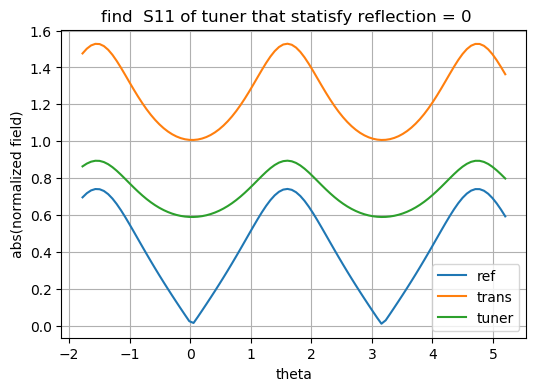

reflection=0.45564074479737127  field at Tuner= 0.5587003700819767

In [23]:
####  if ref_coe1=ref_coe2 this is the case for tuner

ref_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=ref_coe1+(1+ref_coe1)*(1+ref_coe2)*ref_coe3*exp(-1im*2*theta)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))
Tran_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=(1+ref_coe3)*(1+ref_coe1)*exp(-1im*theta)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))
E_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=(1+ref_coe1)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))

    
fig=figure(figsize=(8,3))

Phase_shiftatTest=mod(beta_TE10*(12+30+6)*25.4*1e-3,2pi)-2pi

thetaX=range(Phase_shiftatTest,length=100,stop=Phase_shiftatTest+40pi/180+2pi)

ref_coe3X=Ref_cav_wg[800];ref1_abs= 0.29 #0.7485977 # 0.24232571  42.44# ; 

ref_1=ref1_abs*exp(-1im*(-180)pi/180);ref_2=ref1_abs*exp(-1im*45pi/180);
ref_3=ref1_abs*exp(-1im*30pi/180);ref_4=ref1_abs*exp(-1im*128pi/180)
#reflection
a1_09=map(thetaX->ref_coe_tot(ref_1,ref_1,ref_coe3X,thetaX),thetaX)
a1_08=map(thetaX->ref_coe_tot(ref_2,ref_2,ref_coe3X,thetaX),thetaX)
# transmission
T1_09=map(thetaX->Tran_coe_tot(ref_1,ref_1,ref_coe3X,thetaX),thetaX)
T1_08=map(thetaX->Tran_coe_tot(ref_2,ref_2,ref_coe3X,thetaX),thetaX)
# tunner
E_09=map(thetaX->E_coe_tot(ref_1,ref_1,ref_coe3X,thetaX),thetaX)
E_08=map(thetaX->E_coe_tot(ref_2,ref_2,ref_coe3X,thetaX),thetaX)

fig=figure(figsize=(6,4))
#subplot(121)
plot(thetaX,abs.(a1_09),label="ref");plot(thetaX,abs.(T1_09),label="trans");plot(thetaX,abs.(E_09),label="tuner")
title("find  S11 of tuner that statisfy reflection = 0   ")
xlabel("theta")
ylabel("abs(normalized field)")
grid()
#yscale("log")
legend()

#fig=figure(figsize=(6,4))
#subplot(121)
#plot(thetaX,(a1_09),label="ref");plot(thetaX,(T1_09),label="trans");plot(thetaX,(E_09),label="tuner")
#title("ref_coe3X=0.3;Tuner at 67.74 mm;
#    ref1_abs=0.7485977, ref1_phase=-54.76 degree  ")
#xlabel("theta")
#ylabel("(normalized field)")
#legend()
#grid()
print("reflection=",abs(ref_coe_tot(ref_1,ref_1,0.3,pi/2)),"  field at Tuner= ",abs(E_coe_tot(ref_1,ref_1,-1,Phase_shiftatTest)))

#  if ref_coe1=ref_coe2, and ref_coe3=-1 this is the case for tuner plus shorting plate

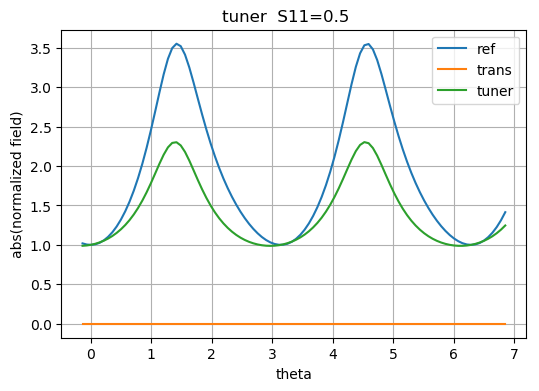

reflection=0.14309656954175268  field at Tuner= 0.9883427441553028

In [52]:
####  if ref_coe1=ref_coe2, and ref_coe3=-1 this is the case for tuner plus shorting plate

ref_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=ref_coe1+(1+ref_coe1)*(1+ref_coe2)*ref_coe3*exp(-1im*2*theta)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))
Tran_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=(1+ref_coe3)*(1+ref_coe1)*exp(-1im*theta)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))
E_coe_tot(ref_coe1,ref_coe2,ref_coe3,theta)=(1+ref_coe1)/(1-ref_coe3*ref_coe2*exp(-1im*2*theta))

    
fig=figure(figsize=(8,3))

Phase_shiftatTest=mod(beta_TE10*(12+30+6)*25.4*1e-3,2pi)-2pi

thetaX=range(Phase_shiftatTest,length=100,stop=Phase_shiftatTest+40pi/180+2pi)

ref_coe3X=-1;ref1_abs= 0.4 #0.7485977 # 0.24232571  42.44# ; 

ref_1=ref1_abs*exp(-1im*(20)pi/180);ref_2=-ref_1;

#reflection
a1_09=map(thetaX->ref_coe_tot(ref_1,ref_1,ref_coe3X,thetaX),thetaX)
a1_08=map(thetaX->ref_coe_tot(ref_2,ref_2,ref_coe3X,thetaX),thetaX)
# transmission
T1_09=map(thetaX->Tran_coe_tot(ref_1,ref_1,ref_coe3X,thetaX),thetaX)
T1_08=map(thetaX->Tran_coe_tot(ref_2,ref_2,ref_coe3X,thetaX),thetaX)
# tunner
E_09=map(thetaX->E_coe_tot(ref_1,ref_1,ref_coe3X,thetaX),thetaX)
E_08=map(thetaX->E_coe_tot(ref_2,ref_2,ref_coe3X,thetaX),thetaX)

fig=figure(figsize=(6,4))
#subplot(121)
plot(thetaX,abs.(a1_09),label="ref");plot(thetaX,abs.(T1_09),label="trans");plot(thetaX,abs.(E_09),label="tuner")
title("tuner  S11=0.5   ")
xlabel("theta")
ylabel("abs(normalized field)")
grid()
#yscale("log")
legend()

#fig=figure(figsize=(6,4))
#subplot(121)
#plot(thetaX,(a1_09),label="ref");plot(thetaX,(T1_09),label="trans");plot(thetaX,(E_09),label="tuner")
#title("ref_coe3X=0.3;Tuner at 67.74 mm;
#    ref1_abs=0.7485977, ref1_phase=-54.76 degree  ")
#xlabel("theta")
#ylabel("(normalized field)")
#legend()
#grid()
print("reflection=",abs(ref_coe_tot(ref_1,ref_1,0.3,pi/2)),"  field at Tuner= ",abs(E_coe_tot(ref_1,ref_1,-1,Phase_shiftatTest)))

In [25]:
find_zero(x^5 - x - 1, 1.0)  # 1.1673039782614185

UndefVarError: UndefVarError: x not defined

# waveguide-conditioning box

In [26]:
# cutoff wavenumber (a is the long side, b is the short side)
Kc_WG(a,b,m,n)=sqrt((m*pi/a)^2+(n*pi/b)^2);
#The cutoff wave length in meter is
lamda_cWG(a,b,m,n)=2pi/(Kc_WG(a,b,m,n));
# the cutoff frequency
fc_WG(a,b,m,n)=clight/lamda_cWG(a,b,m,n);
#phase constant of a wave
Kapa(lamda)=2pi/lamda;
beta(a,b,m,n,lamda)=sqrt(Kapa(lamda)*Kapa(lamda)-Kc_WG(a,b,m,n)*Kc_WG(a,b,m,n));


In [27]:

#FPC conditioing box 
a1=11.6*0.0254;b1=2.9*0.0254;
f0=704*1e6;
lamda0=clight/f0
omega0=2*pi*f0
lamda_guide=lamda0/sqrt(1-(lamda_cWG(a1,b1,1,0)/lamda0)^-2)
beta_TE10=beta(a1,b1,1,0,lamda0);
lamda_guide

0.6160750413346898

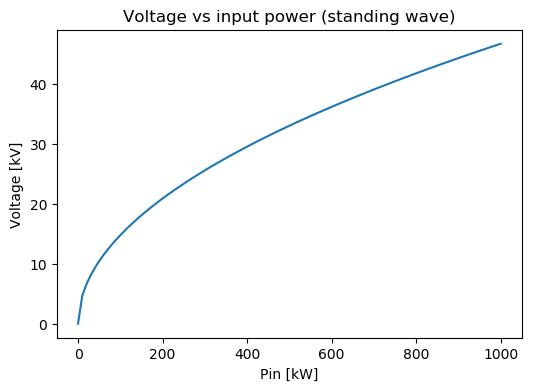

Vm(600kW,50ohm)=20.0  V0_TE10(600 kW)=46.69152563860181

In [28]:
V0_TE10(P)=sqrt(P*4*omega0*mu0/(a1*b1*beta_TE10))*b1*2*1e-3 # kV
fig=figure(figsize=(6,4))
plot(P,map(P->V0_TE10(P*1e3),P))
xlabel("Pin [kW]")
ylabel("Voltage [kV]")
title("Voltage vs input power (standing wave)")
print("Vm(600kW,50ohm)=",Vm(1000000,50),"  V0_TE10(600 kW)=",V0_TE10(1000000))

# permitivity and permibility parameters measurements

In [29]:
frequency=8*1e9 
# 1.25 GHz
S11=0.856*exp(1im*163.2*pi/180)
S21=0.609*exp(1im*-140.5*pi/180)
#1.8GHz
#S11=-0.23164684-1im*0.70083233;
#S21=0.63956247-1im*0.21175182;
#1.5GHz
#S11=0.45316748+1im*(-0.52078579)
#S21=0.54516218+1im*(0.47431635)
#0.6GHz
#S11=-0.28340127+1im*(0.26030177)
#S21=-0.62309687+1im*(-0.68036708)
#S11=0.33933347+1im*(0.17711668)
#S21=-0.42891988+1im*(0.81739999)

sample_d=0.4  #(8.02mm)

KX=(S11^2-S21^2+1)/2/S11;

if abs(KX-sqrt(KX^2-1))>1
    Gama_reflect=(KX+sqrt(KX^2-1))
else
    Gama_reflect=(KX-sqrt(KX^2-1))
end
T_transmit=(S11+S21-Gama_reflect)/(1-(S11+S21)*Gama_reflect)
abs_T=abs(T_transmit); phase_T=angle(T_transmit)

x1=log(1/T_transmit)
x20=-(log(1/T_transmit)/(2pi*sample_d))^2
x2=sqrt(-(log(1/T_transmit)/(2pi*sample_d))^2)
x3=(1+Gama_reflect)/(1-Gama_reflect)

mur=x2*x3/sqrt(1/3.75/3.75-1/5.703/5.703*0)
espir=3.75*3.75/mur*(1/5.703/5.703*0+x20)

7.250290619879319 + 9.320527184262762im

In [30]:
frequency=8*1e9 
# 1.25 GHz
S11=0.856*exp(1im*163.2*pi/180)
S21=0.609*exp(1im*-140.5*pi/180)
#1.8GHz
S11=-0.23164684-1im*0.70083233;
S21=0.63956247-1im*0.21175182;
#1.5GHz
S11=0.45316748+1im*(-0.52078579)
S21=0.54516218+1im*(0.47431635)
#0.6GHz
#S11=-0.28340127+1im*(0.26030177)
#S21=-0.62309687+1im*(-0.68036708)
#S11=0.33933347+1im*(0.17711668)
#S21=-0.42891988+1im*(0.81739999)

sample_d=8.02*1e-3  #(8.02mm)

KX=(S11^2-S21^2+1)/2/S11;

if abs(KX-sqrt(KX^2-1))>1
    Gama_reflect=(KX+sqrt(KX^2-1))
else
    Gama_reflect=(KX-sqrt(KX^2-1))
end
T_transmit=(S11+S21-Gama_reflect)/(1-(S11+S21)*Gama_reflect)
abs_T=abs(T_transmit); phase_T=angle(T_transmit)




Gama_propagate=1im*(-log(abs_T)-1im*(phase_T+0*pi))/sample_d


eta_imped=1im*2pi*frequency*mu0/Gama_propagate
Gama_propagate0=2pi/(clight/frequency);

xx2=Gama_propagate/Gama_propagate0*(1-Gama_reflect)/(1+Gama_reflect)

#[Gama_propagate Gama_propagate0]
Gama_propagate/Gama_propagate0
xx=eta_imped^2/(2pi*frequency)^2/mu0
[(abs(Gama_propagate)/Gama_propagate0)  imag(xx)/real(xx)]


## reference 
eta_s=377*sqrt(((1+S11)^2-S21^2)/((S11-1)^2-S21^2))
eta_0=377
ZA=S21*(eta_s+eta_0)/((eta_s+eta_0)-S11*(eta_s-eta_0))
ZB=((eta_s-eta_0)-S11*(eta_s+eta_0))/S21/(eta_s-eta_0)
Ks=(1im*log(abs(ZA))-angle(ZA)-0*pi)/sample_d

epsi_s=Ks/(2pi*frequency)/eta_s/eps0

[epsi_s   imag(epsi_s)/real(epsi_s)   xx2]


1×3 Array{Complex{Float64},2}:
 0.0348202-0.000444542im  -0.0127668+0.0im  -0.0348444+0.000444851im

In [31]:
# import an excel file 
Sparameter=XLSX.readdata("Sparameters.xlsx", "Sheet1", "A:H") ;
freq1=(Sparameter[:,1])[2:end];S11_linear=(Sparameter[:,2])[2:end];S11_phase=(Sparameter[:,4])[2:end];
S21_linear=(Sparameter[:,6])[2:end];S21_phase=(Sparameter[:,8])[2:end];
epsi_measured=zeros(Complex{Float64},length(freq1));tan_loss=zeros(Complex{Float64},length(freq1));
epsi_2=zeros(Complex{Float64},length(freq1));tan_measured=zeros(Complex{Float64},length(freq1));

for i=1: length(freq1)
    frequency=freq1[i]*1e9 
    wavelength=clight/frequency
    S11=S11_linear[i]*exp(1im*S11_phase[i]*pi/180)
    S21=S21_linear[i]*exp(1im*S21_phase[i]*pi/180)
    sample_d=0.802*1e-2  #(8.02mm)

KX=(S11^2-S21^2+1)/2/S11;

if abs(KX-sqrt(KX^2-1))>1
    Gama_reflect=(KX+sqrt(KX^2-1))
else
    Gama_reflect=(KX-sqrt(KX^2-1))
end
T_transmit=(S11+S21-Gama_reflect)/(1-(S11+S21)*Gama_reflect)
abs_T=abs(T_transmit); phase_T=angle(T_transmit)
Gama_propagate=-1im*(-log(abs_T)-1im*(phase_T+0*2*pi))/sample_d
  
 
F=(1-Gama_reflect)/(1+Gama_reflect)    

kz=(0-phase_T/2/pi)/(sample_d/wavelength)+1im*abs_T/2/pi/((sample_d/wavelength))
    
esp_r=kz*F    
    

eta_imped=1im*2pi*frequency*mu0/Gama_propagate
Gama_propagate0=2pi/(clight/frequency);

xx2=Gama_propagate/Gama_propagate0*(1-Gama_reflect)/(1+Gama_reflect)

#[Gama_propagate Gama_propagate0]
Gama_propagate/Gama_propagate0
xx=eta_imped^2/(2pi*frequency)^2/mu0
[(abs(Gama_propagate)/Gama_propagate0)  imag(xx)/real(xx)]


## reference 
eta_s=377*sqrt(((1+S11)^2-S21^2)/((S11-1)^2-S21^2))
eta_0=377
ZA=S21*(eta_s+eta_0)/((eta_s+eta_0)-S11*(eta_s-eta_0))
ZB=((eta_s-eta_0)-S11*(eta_s+eta_0))/S21/(eta_s-eta_0)
Ks=(1im*log(abs(ZB))-angle(ZB)-0pi)/sample_d

 epsi_s=Ks/(2pi*frequency)/eta_s/eps0
  epsi_measured[i]= epsi_s
  tan_loss[i]=  imag(esp_r)/real(esp_r)
  tan_measured[i]=  imag(epsi_s)/real(epsi_s)
  epsi_2[i]=esp_r
    

#[epsi_s   imag(epsi_s)/real(epsi_s)   xx2]
end




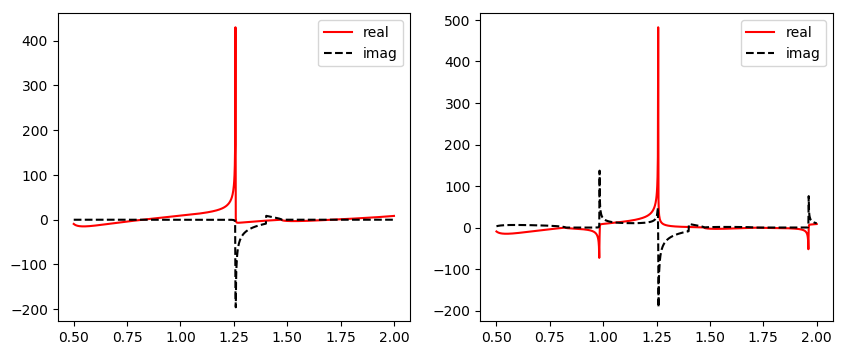

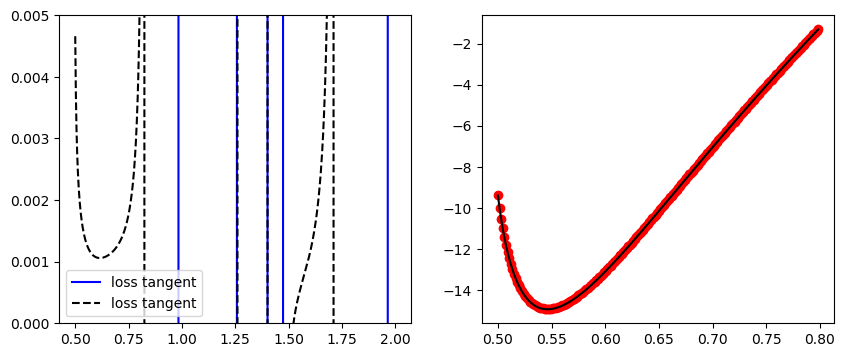

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000352F6CF8>

In [32]:
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1[1:end],real.(epsi_measured[1:end]),"r-",label="real")
plot(freq1[1:end],imag.(epsi_measured[1:end]),"k--",label="imag")
legend()
subplot(122)
plot(freq1[1:end],real.(epsi_2[1:end]),"r-",label="real")
plot(freq1[1:end],imag.(epsi_2[1:end]),"k--",label="imag")
#ylim(0,105)
legend()
#plot(freq1[1:500],real.(tan_loss[1:500]),"b-")

[mean(abs.(epsi_measured[1:end])) mean(abs.(tan_loss[1:300]))]
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1[1:end],real.(tan_loss[1:end]),"b-",label="loss tangent")

plot(freq1[1:end],real.(tan_measured[1:end]),"k--",label="loss tangent")
ylim(0,5e-3)
legend()
subplot(122)
plot(freq1[1:200],real.(epsi_measured[1:200]),"ro",label="real")
plot(freq1[1:200],real.(epsi_2[1:200]),"k-",label="real")

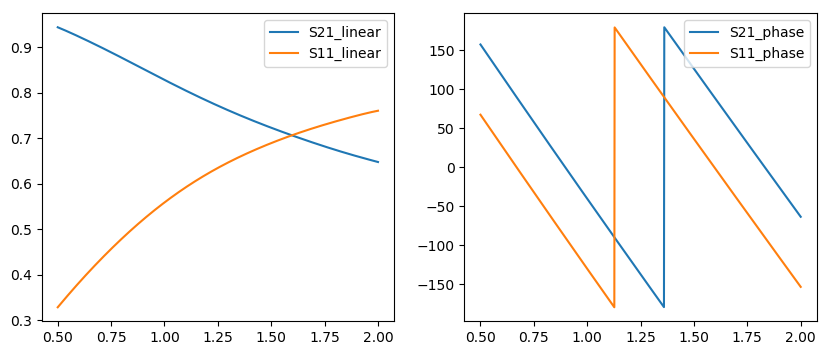

PyObject <matplotlib.legend.Legend object at 0x000000005C14A710>

In [33]:
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1,S21_linear,label="S21_linear")
plot(freq1,S11_linear,label="S11_linear")
legend()
subplot(122)
plot(freq1,S21_phase,label="S21_phase")
plot(freq1,S11_phase,label="S11_phase")
legend()

In [34]:
#Lorentz model
epss=9.4;espoo=2

eps(f)=espoo+(esps-espoo)/(1+1im*df/f)


eps (generic function with 1 method)

# Tryout

In [44]:
# import an excel file 
Sparameter=XLSX.readdata("SiC_onTransmissionline_1srTry.xlsx", "SiC_onTransmissionline_1srTry", "A:I") ;
freq1=(Sparameter[:,1])[8:end];S11_linear=(Sparameter[:,2])[8:end];S11_phase=(Sparameter[:,3])[8:end];
S21_linear=(Sparameter[:,6])[8:end-1];S21_phase=(Sparameter[:,7])[8:end];
epsi_measured=zeros(Complex{Float64},length(freq1));tan_loss=zeros(Complex{Float64},length(freq1));
epsi_2=zeros(Complex{Float64},length(freq1));tan_measured=zeros(Complex{Float64},length(freq1));


In [46]:
freq1[end]

2000000000

In [47]:
# import an excel file 
Sparameter=XLSX.readdata("SiC_onTransmissionline_1srTry.xlsx", "SiC_onTransmissionline_1srTry", "A:I") ;
#Sparameter=XLSX.readdata("SiC_transmissionline2GHz.xlsx", "S21S11_transmission line2GHz", "A:I") ;

freq1=(Sparameter[:,1])[8:end-1];S11_linear=(Sparameter[:,2])[8:end-1];S11_phase=(Sparameter[:,3])[8:end-1];
S21_linear=(Sparameter[:,6])[8:end-1];S21_phase=(Sparameter[:,7])[8:end-1];
epsi_m=zeros(Complex{Float64},length(freq1));tan_loss=zeros(Complex{Float64},length(freq1));
epsi_2=zeros(Complex{Float64},length(freq1));tan_m=zeros(Complex{Float64},length(freq1));

for i=1: length(freq1)
    frequency=freq1[i]
    wavelength=clight/frequency
   # if i<findmax(S21_phase)[2]
       S11=S11_linear[i]*exp(1im*S11_phase[i]*pi/180)
       S21=S21_linear[i]*exp(1im*S21_phase[i]*pi/180)
   # else    
   #    S11=S11_linear[i]*exp(1im*S11_phase[i]*pi/180)
   #    S21=S21_linear[i]*exp(1im*(S21_phase[i]-180)*pi/180)
    #end
    sample_d=0.802*1e-2  #(8.02mm)

KX=(S11^2-S21^2+1)/2/S11;

if abs(KX-sqrt(KX^2-1))>1
    Gama_reflect=(KX+sqrt(KX^2-1))
else
    Gama_reflect=(KX-sqrt(KX^2-1))
end
T_transmit=(S11+S21-Gama_reflect)/(1-(S11+S21)*Gama_reflect)
abs_T=abs(T_transmit); phase_T=angle(T_transmit)
Gama_propagate=-1im*(-log(abs_T)-1im*(phase_T+0*2*pi))/sample_d
  
 
F=(1-Gama_reflect)/(1+Gama_reflect)    

kz=(0-phase_T/2/pi)/(sample_d/wavelength)+1im*abs_T/2/pi/((sample_d/wavelength))
    
esp_r=kz*F  
 
epsi_2[i]=esp_r
tan_loss[i]=  imag(esp_r)/real(esp_r)    
    
##### In the following, a different calculation ###
eta_imped=1im*2pi*frequency*mu0/Gama_propagate
Gama_propagate0=2pi/(clight/frequency);

xx2=Gama_propagate/Gama_propagate0*(1-Gama_reflect)/(1+Gama_reflect)

#[Gama_propagate Gama_propagate0]
Gama_propagate/Gama_propagate0
xx=eta_imped^2/(2pi*frequency)^2/mu0
[(abs(Gama_propagate)/Gama_propagate0)  imag(xx)/real(xx)]


## reference 
eta_s=377*sqrt(((1+S11)^2-S21^2)/((S11-1)^2-S21^2))
eta_0=377
ZA=S21*(eta_s+eta_0)/((eta_s+eta_0)-S11*(eta_s-eta_0))
ZB=((eta_s-eta_0)-S11*(eta_s+eta_0))/S21/(eta_s-eta_0)
Ks=(1im*log(abs(ZB))-angle(ZB)-0*2pi)/sample_d

  epsi_s=Ks/(2pi*frequency)/eta_s/eps0
   
  epsi_m[i]= epsi_s
  tan_m[i]=  imag(epsi_s)/real(epsi_s)
  

    

#[epsi_s   imag(epsi_s)/real(epsi_s)   xx2]
end




In [53]:
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1[1:end],real.(epsi_measured[1:end]),"r-",label="real")
plot(freq1[1:end],imag.(epsi_measured[1:end]),"k--",label="imag")
title("epsi measurement")
xlabel("frequency")
ylabel("epsi_mr")
ylim(-50,50)
legend()
subplot(122)
plot(freq1[1:end],real.(epsi_2[1:end]),"rd-",label="real")
plot(freq1[1:end],imag.(epsi_2[1:end]),"k--",label="imag")
title("epsi 2")
xlabel("frequency")
ylabel("epsi_r")
#ylim(0,60)
#ylim(0,105)
legend()
#plot(freq1[1:500],real.(tan_loss[1:500]),"b-")

#[mean(abs.(epsi_measured[1:end])) mean(abs.(tan_loss[1:300]))]
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1[1:end],real.(tan_loss[1:end]),"b-")
plot(freq1[1:end],real.(tan_measured[1:end]),"k--")
subplot(122)
plot(freq1[1:end],real.(epsi_measured[1:end]),"ro",label="real")
plot(freq1[1:end],real.(epsi_2[1:end]),"k-",label="real")
title("epsi measurement")
ylim(0,50)
xlabel("frequency")
ylabel("epsi_r")

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\wxu\.julia\packages\PyCall\ttONZ\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (131974,) and (131975,)',)
  File "C:\Users\wxu\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2811, in plot
    is not None else {}), **kwargs)
  File "C:\Users\wxu\.julia\conda\3\lib\site-packages\matplotlib\__init__.py", line 1810, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\wxu\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 1611, in plot
    for line in self._get_lines(*args, **kwargs):
  File "C:\Users\wxu\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 393, in _grab_next_args
    yield from self._plot_args(this, kwargs)
  File "C:\Users\wxu\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 370, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\wxu\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 231, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))


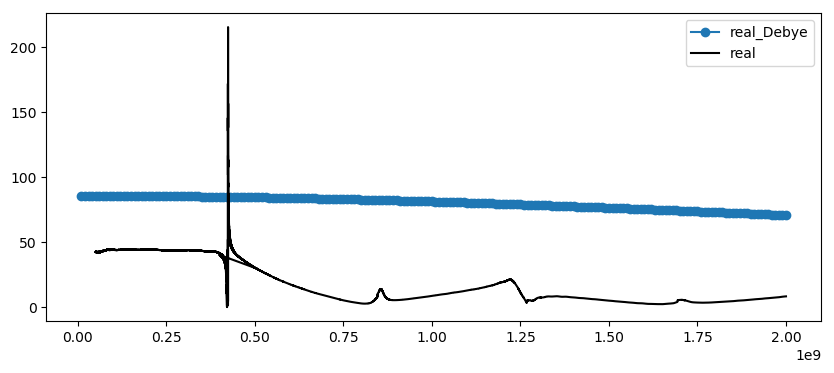

PyObject <matplotlib.legend.Legend object at 0x000000005C1BDF60>

In [42]:
# Debye model
epsr0=85.7;epsroo=13.6;Tau_relaxation=2.55e-10
eps_Debye(w)=epsroo+(epsr0-epsroo)/(1-1im*w*Tau_relaxation)
w=0.1e8:0.1e8:2e9;
eps_D=map(w->eps_Debye(w),w)
fig=figure(figsize=(10,4))
#subplot(121)
plot(w,real(eps_D),label="real_Debye","o-")
plot(freq1[1:end],abs.(real.(epsi_2[1:end])),"k-",label="real")
#legend()
#subplot(122)
#plot(w,imag(eps_D),label="imag_Debye","sk--")
legend()

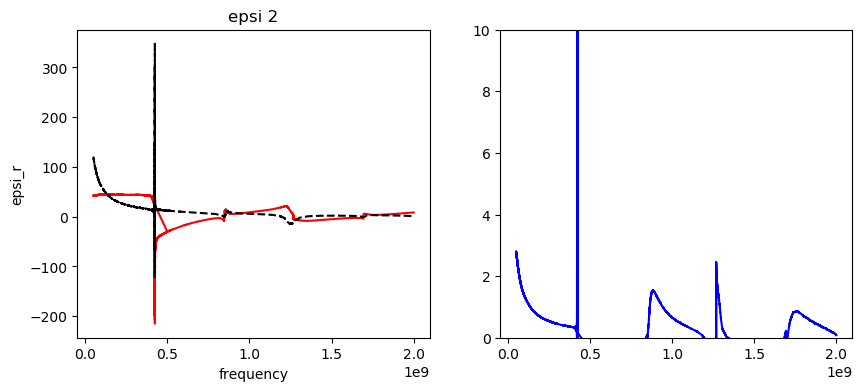

(0, 10)

In [48]:
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1[1:end],real.(epsi_2[1:end]),"r-",label="real")
plot(freq1[1:end],imag.(epsi_2[1:end]),"k--",label="imag")
title("epsi 2")
xlabel("frequency")
ylabel("epsi_r")

subplot(122)
plot(freq1[1:end],real.(tan_loss[1:end]),"b-")

#plot(freq1[1:end],real.(tan_measured[1:end]),"k--")
ylim(0,10)

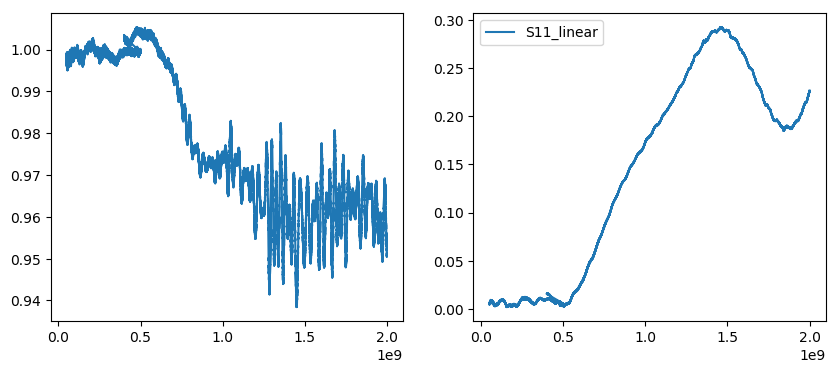

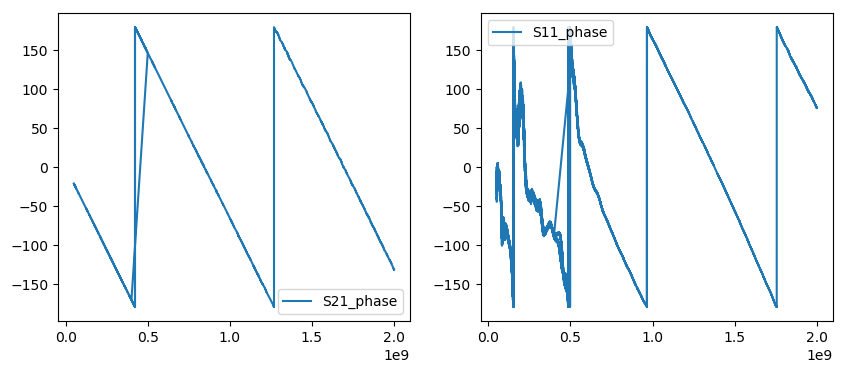

PyObject <matplotlib.legend.Legend object at 0x00000000C2F8A048>

In [40]:
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1,S21_linear,label="S21_linear")
subplot(122)
plot(freq1,S11_linear,label="S11_linear")
legend()
fig=figure(figsize=(10,4))
subplot(121)
plot(freq1,S21_phase,label="S21_phase")
legend()
subplot(122)
plot(freq1,S11_phase,label="S11_phase")
legend()

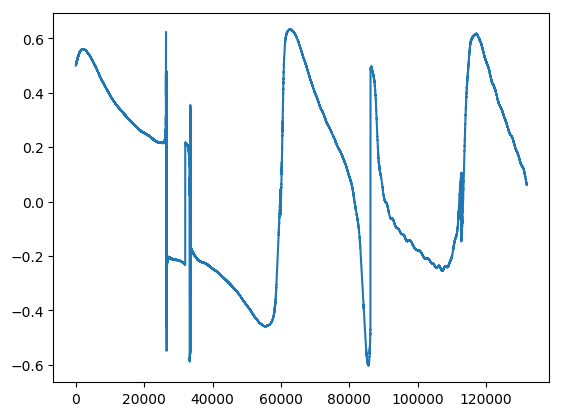

L1=0.43107621955972203  L2=0.40313640127882605 L3= 0.8342126208385481

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000066E1AE10>

In [41]:
#gap correction
D1=9.315*2;   # inner conductor diameter
D2=D1;    # SiC ring innner diameter
D3=27.88   # SiC ring OD
D4=D1*2.303  # outer conductor OD
L1=log(D2/D1)+log(D4/D3);
L2=log(D3/D2);
L3=log(D4/D1);
print("L1=",L1,"  L2=",L2," L3= ",L3)
epsi_c=real.(epsi_2).*L2./(L3.-real.(epsi_2).*L1)
#tan_m=tan_loss[4000]
#real_loss=tan_loss[4000]*epsi_c*L3/(L3-L1*epsi_c*(1+tan_loss[4000]^2))
real_loss=real.(tan_loss).*epsi_c.*L3./(L3.-L1.*epsi_c.*(1 .+tan_loss.^2))
plot(-real_loss)

# Filter design

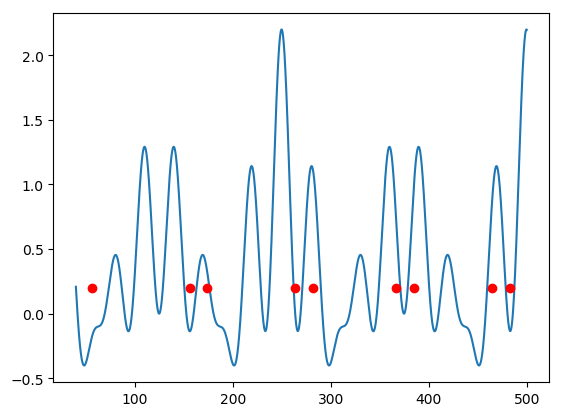

Z1=116.66666666666667

In [126]:
function ref_fourier1(theta,r0,theta0,r1,theta1,r2,theta2,r3,r4) #,theta3,r4,theta4,r5,theta5)
    N=9
    a0=r0*cos(N*theta)
    a1=r1*cos((N-2)*theta)
    a2=r2*cos((N-4)*theta)
    a3=r3*cos((N-6)*theta)
    a4=r4*cos((N-4)*theta)
 #   a5=
    return 2*exp(-1im*N*theta)*(a0+a1+a2+a3+a4)
end
freqx=range(40,length=1000000,stop=500);
Kwave=2pi*freqx*1e6/clight

thetax=Kwave*0.6
r01=0.4;r21=r0;r11=0.1;r31=r11;r41=r01

ref_fourierX=map(thetax->ref_fourier1(thetax,r01,thetax,r11,thetax,r21,thetax,r31,r41),thetax);
plot(freqx,ref_fourierX)
freq56=[56,165-9,165+9,273-9,273+9,376+9,376-9,474+9,474-9];
freq56line=0.2*[1,1,1,1,1,1,1,1,1];
plot(freq56,freq56line,"ro")
print("Z1=",50*(1+r01)/(1-r01))

In [103]:
clight/56/1e6

5.35343675

# Cavity 

In [1335]:
# Ring parameters
Crev=3834.9; frev=clight/Crev; f9MHz=frev*120; f28MHz=frev*360; T28MHz=1/f28MHz; f56MHz=frev*720
harm1=720*10; frf=f56MHz*10*Hz;dT=Crev/clight/360*1e6 # in usec

gammat=31. ; gamma0=9.785e3 ; vrf=22.0e6;phisynch=170.5*pi/180; omegarf=2*pi*frf;Trf=1/frf;
trev=Crev/clight;omega_rev=2*pi/trev;
ebeta= sqrt(1-1/gamma0^2)
eta = 1/gammat^2 - 1/gamma0^2;
r0=qe^2/me0/clight^2;
pcoeff = -1*vrf*omegarf/(0.511e6)  # this "0.511 MeV" has to change to 9.38e6 for proton
synchronous_volt= vrf*sin(phisynch)
tcoeff = trev*eta/(ebeta^2*gamma0)
rcoeff = pcoeff/tcoeff
synchrotron_tune = sqrt(-pcoeff*tcoeff)/(2*pi)
tunesexact = acos(1+pcoeff*tcoeff/2)/(2*pi)
fsyn = synchrotron_tune/trev
print("#############")
print("synchrotron_tune=",synchrotron_tune,",  fsyn=",fsyn,", frf=",frf/1e6,", eta=",eta)
# Getinput

iseed=171487 ;
aatom=1 ; qatom=1.  ; taupart=0.65e-11 ; tauhat=1.87e-10  ;
harmbtf=0.1 ; phibtf=1.
tradperp=5.e-2  ; sigperp=3.6e-4   #nominal rms transverse size
tradlong=2.5e-2 ; siglong=5.4

print("fsyn=",fsyn)
eta

#############synchrotron_tune=0.0724324071397075,  fsyn=5662.387383052925, frf=562.8584050692326, eta=0.0010405722820507415fsyn=5662.387383052925

0.0010405722820507415

In [1348]:
# bunch pattern
Nbucket=315*4;Nbunch=290*4;Ngap=Nbucket-Nbunch;Nbeam_turn=100;
beamXturn=vcat(ones(Complex,Nbunch),zeros(Complex,Ngap));
currentfactor=1; m=1;modx=1;modtimes=0
for i=1:Nbeam_turn-1
    if mod(i,modx)==0
        currentfactor=1+m*modtimes
        m=m+1
    end
    append!(beamXturn,currentfactor*vcat(ones(Nbunch),zeros(Ngap)))
    i=i+1
end
length(beamXturn)

# Time span
Crev=3833.845;frev=cc/Crev; harm1=315; frf=frev*315*24  # (591 MHz)
fbunch=(frev*Nbucket); Tb=1/fbunch;dt_bunch=1/fbunch;Tbeam=2/frev;

Nwait=10;Nfall=0;Nfill=500;Nbeam_delay=0;Nflat=Nbucket*Nbeam_turn;Nturn_beamoff_early=0;Nend=Nwait+Nfill+Nflat+Nfall
Nbeam_off=Nend+1

#Qb0=3.0*1e10*qe;Ib0=-Qb0*Nbunch*frev; 
Ib0=-0.13550370696559326
Ib_eRHIC2=Ib0*vcat(0,zeros(Complex,Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Complex,Nfall+Nturn_beamoff_early));
Qb=Ib0/(Nbunch*frev)*vcat(0,zeros(Complex,Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Complex,Nfall+Nturn_beamoff_early));
#plot(Ib_eRHIC2)
length(Ib_eRHIC2),Nend,length(Qb)

(126511, 126510, 126511)

In [1343]:
deltaVpp_formula=0.5*wo*RoQ*Nbunch*Ib0/(Nbunch*frev)*(1-Nbunch*frev/fbunch)*1e-6



-0.03729106510914571

In [1344]:



Q0=2e10;RoQ=146;Z0=50;Lcav=0.5352;deltaf=5e2;Qload=3e5  #2.5e4;
fres=frf-deltaf #predetune in Hz
rho=RoQ/2; # (rho is the half of Rshunt/Qo, i.e circuit definition)
Rsh=Q0*RoQ;R=Rsh/2;wo=2*pi*fres;Tfill=2*Qload/wo;w12=wo/(2Qload);Rload=rho*Qload; #( Rload is circuit definition)
#n_coupler=sqrt(R/Z0*Qload/(Q0-Qload));
beta_coupler=Q0/Qload-1;dUdt=zeros(Nend);n_coupler=sqrt(R/beta_coupler/Z0);tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)

dt=dt_bunch;Tend=Nend*dt;Tsim=0:dt:Tend; Ntgrid=length(Tsim);
#dt=10/frf;Tend=60*Tfill;Tsim=0:dt:Tend; Ntgrid=length(Tsim);
Nwait=Nwait;Nfall=Nfall;
Nbeam_in=Nwait+Nfill+Nbeam_delay;Nbeam_on=Nbunch;Nbeam_gap=Ngap
#Nbeam_in=Int(floor(8.0Tfill/dt));Nbeam_on=Int(floor(10.0Tfill/dt));Nbeam_gap=Int(floor(10.0Tfill/dt))
Nfb=Nwait+0

Ib0=-0.13550370696559326
Ibx=Ib0*vcat(0,zeros(Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Complex,Nfall+Nturn_beamoff_early));
#plot(Ibx)
Ntgrid,length(Ibx)

(126511, 126511)

In [1345]:
#Ib=vcat(zeros(Nbeam_in),Ib0*ones(Complex,Ntgrid-Nbeam_in))
Ib=Ibx
vrf=4.0e6;phisynch=110*pi/180
synchronous_volt= vrf*sin(phisynch)

sp_ampl=synchronous_volt/sin(phisynch);sp_phase=(pi/2-(pi-phisynch))*180/pi*deg;
set_Volt=sp_ampl*exp(1im*sp_phase*pi/180)

if sp_phase==0
  Ix=0
else
  Ix=(deltaf/(w12/2/pi))/(RoQ*Q0*sin(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))
end

function Pg_power(currentfactor)
  a1=sp_ampl^2/4/RoQ/Q0*(beta_coupler+1)^2/beta_coupler;
  a2=(1+RoQ*Q0*abs(Ib0*currentfactor)*cos(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))^2;
  a3=(deltaf*currentfactor/(w12/2/pi)+RoQ*Q0*(Ib0*currentfactor)*sin(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))^2;
  Pg=a1*(a2+a3)/1e6;
  return Pg,a1,a2,a3
end
Pg,a3=Pg_power(1), Ix
#Pb_ideal=sp_ampl*sin(pi/180*sp_phase)*Ib0, Ix



((0.5235324052750464, 91325.57079680395, 5.7325938475492695, 1.492257694676178e-11), 0.13550267549676065)

In [1354]:
# ceated mechanical model
mech_fm=[50 30 100];mech_Qm=[100 100 100];mech_Km=[0.4 0.3 0.2]*1e-12;mech_DW=zeros(3,Ntgrid);
mech_dDWdt=zeros(3,Ntgrid);mech_time=0;mech_wave=0;mech_uphonics=0 ;#+/- Hz detuning due to microphonics
mech_wm=2*pi*mech_fm;
mech_uphonics=30 ;#+/- Hz detuning due to microphonics


In [1359]:
# Coupling
dir_BeamOn=1; dir_LFD=1;dir_track=1;dir_FB=1;wakeON=0;Rad_on=0
Pow_max=Pg[1]*1e6;Ikly0=sqrt(Pow_max*2/Rload)
kly_Ifwd=Ikly0*vcat(zeros(Nwait),ones(Ntgrid-Nwait-Nfall)*exp(1im*0pi/180),zeros(Nfall));kly_Pfor=zeros(Complex,Ntgrid);
kly_Pref=zeros(Complex,Ntgrid);dUdt2=zeros(Ntgrid);dUdt=zeros(Ntgrid);
DT_sim=dt; deltaW= 2pi*real(deltaf)*ones(Complex,Ntgrid)+2*pi*(2*rand(Ntgrid)-ones(Ntgrid))*mech_uphonics
Itotal_sim=zeros(Complex,Ntgrid);Vc_sim=zeros(Complex,Ntgrid);Vwg_for=zeros(Complex,Ntgrid);Vwg_ref=zeros(Complex,Ntgrid);
Ref_wg=zeros(Complex,Ntgrid);
Icav_sim=zeros(Complex,Ntgrid); Pbeam=zeros(Complex,Ntgrid);Vb=zeros(Complex,Ntgrid);Vg=zeros(Complex,Ntgrid)
detune_sim=deltaW; Isp_sim=zeros(Complex,Ntgrid);Icav_sim=zeros(Complex,Ntgrid);
err_sim=zeros(Complex,Ntgrid);err_phase=zeros(Complex,Ntgrid)

# Initial delta_gamma and delta_t of the bunch
gamma0=9.785e3;iseed=171487 ;delta_gamma_all=zeros(Complex{Float64},Ntgrid);delta_t2_all=zeros(Complex{Float64},Ntgrid)
delta_syn_phase=zeros(Complex{Float64},Ntgrid);bunch_Vb=zeros(Complex{Float64},Ntgrid)
bunch_Vb2=zeros(Complex{Float64},Ntgrid); delta_gamma2_ini=rand(Normal(0, gamma0*1e-9), iseed)[1:Nbunch];
delta_t2_ini=rand(Normal(0, taupart*1e-3), iseed)[1:Nbunch];

#Feedback setting
klyGain_dB=1;kly_gain=10^(klyGain_dB/20);kly_phase=0;Kp_sim=100;Ki_sim=10;sysgain=2;FB_i=0;FB_p=0;FB_corr=0
ph_corr=0;ph_p=0;ph_i=0

for nx=2:Ntgrid
    fres=frf-detune_sim[nx-1]/2/pi
    tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)
    Isp_sim[nx] = set_Volt/(Rload*cos(atan(tanPsi)))
    Icav_sim[nx-1]=Vc_sim[nx-1]/(Rload*cos(atan(tanPsi)))
    # feedbakc   
    FB_corr=0;
    Nloopdelay_sim=0;
    if dir_FB==1 && nx>Nloopdelay_sim+1 
        Nfb_start=Nfb
        Nfb_stop=Ntgrid-Nfall; #stop the feedback at the end of RF pulse
        if nx>Nfb_start && nx <=Nfb_stop
            err_sim[nx]=Isp_sim[nx]-Icav_sim[nx-1-Nloopdelay_sim]   #error
            FB_p=Kp_sim*err_sim[nx]  # proportional gain
            FB_i=FB_i+Ki_sim*err_sim[nx]*DT_sim  # Integral gain
            FB_corr=sysgain*(FB_p+FB_i)
         end   
    
      kly_Ifwd[nx]=kly_Ifwd[nx]+FB_corr;

     #Klystron (gain and phase correction) +clamper
      kly_Ifwd[nx] = kly_Ifwd[nx]*kly_gain*exp(1im*kly_phase)
   end    # End of feedback

    
    #Pfwd clamper
    
# Voltage generated by klystron
  # tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)
  # Zcav=Q0*RoQ/(1-1im*(1+beta_coupler)*tanPsi)
  # Zload=Qload*RoQ/(1-1im*tanPsi)
   Vg[nx]=Rload*2*kly_Ifwd[nx]*(1-exp(-w12*nx*DT_sim))   
    
   if nx>= Nbeam_in
    Itotal_sim[nx]=2*kly_Ifwd[nx]+2*Ib[nx]*dir_BeamOn # *dir_BeamOn # Here I use kly_ifwd are positive, Ib is positive,
    
    Vb[nx]=Rload*2*Ib[nx]*(1-exp(-w12*(nx-Nbeam_in)*DT_sim))    
   
        
   else
    Itotal_sim[nx]=2*kly_Ifwd[nx]
   end
    
   #Icav_sim[nx-1]=Vc_sim[nx-1]/(Rload*cos(atan(tanPsi))) 
   # compute cavity voltage
   #Vc_sim[nx]=(Vc_sim[nx-1]+0.5*DT_sim*rho*wo*Itotal_sim[nx])/(1+DT_sim*(w12-1im*deltaW))   # seen in the cavity side
    
   Vc_sim[nx]=(Vc_sim[nx-1]+1*DT_sim*Rload*w12*Itotal_sim[nx])/(1+DT_sim*(w12-1im*real(deltaW[nx])))
   
    # Lorentz detuning
    if dir_LFD==1 && nx>2
        pzt=0
        # Detuning omega in rad
        # mode#1
        for nmode=1:3
        a11=(2+DT_sim*mech_wm[nmode]/mech_Qm[nmode])*mech_DW[nmode,nx-1]-mech_DW[nmode,nx-2]
        a12=DT_sim^2*(2*pi*mech_Km[nmode]*mech_wm[nmode]^2*abs(Vc_sim[nx])^2/Lcav^2-pzt)
        a3=1+(DT_sim*mech_wm[nmode])^2+DT_sim*mech_wm[nmode]/mech_Qm[nmode]
        mech_DW[nmode,nx]=(a11-a12)/a3
        end
        # total detuning xxx
              
        deltaW[nx]=real(deltaW[nx])-sum(mech_DW[:,nx])
       # tanPsi_new=2*Qload*deltaW/wo
        
        # rcompute the cavity voltage this is essential the same as the one above
        Vc_sim[nx]=(Vc_sim[nx-1]+1*DT_sim*Rload*w12*Itotal_sim[nx])/(1+DT_sim*(w12-1im*real(deltaW[nx])))
    end  # end of Lorentz detuning
    # store total detuning
   detune_sim[nx]=deltaW[nx]  #in rad
    
       
   kly_Pfor[nx]=0.5*Rload*kly_Ifwd[nx]^2
   
    
   Vwg_for[nx]=sqrt(kly_Pfor[nx]*2*Z0)
    
   dUdt2[nx]=abs(Vc_sim[nx])^2/RoQ/Q0
   dUdt[nx]=2*(real(Vc_sim[nx])*(real(Vc_sim[nx])-real(Vc_sim[nx-1]))+ imag(Vc_sim[nx])*(imag(Vc_sim[nx])-imag(Vc_sim[nx-1])))/(wo*RoQ*DT_sim)
 # 
    
#   kly_Pref2[nx]=(kly_Ifwd[nx]*n_coupler-Vc_sim[nx]/(n_coupler*Z0))^2*Z0/2
    
   Vwg_ref[nx]= Vc_sim[nx]/n_coupler-Vwg_for[nx]
 #
    
   if real(Vwg_for[nx])>0
        Ref_wg[nx]= Vwg_ref[nx]/Vwg_for[nx]
   end
   if nx> Nbeam_in && dir_BeamOn==1
    Pbeam[nx]=-real(Vc_sim[nx])*real(Ib[nx])*sin(angle(Ib[nx])-angle(Vc_sim[nx]))  
             
   end
      kly_Pref[nx]=kly_Pfor[nx]-dUdt[nx]-Pbeam[nx]
    
    # Add beam phase due to bunch oscillation in a turn.
   Vbwake=0
   omegaCav=omegarf-detune_sim[nx]
   
   if nx >= Nbeam_in+1 && nx < Ntgrid && dir_BeamOn==1
        
     Vb0=-0.5*RoQ*omegaCav*Qb[nx]  
      #Vb0=Qbfactor*Qb[nx]*wakemode(omegarf,RoQ,Qload,0)#*cos(detuneAngle[nx])*exp(1im*detuneAngle[nx]) 
    delta_gamma_all[nx]=delta_gamma_all[nx]  # before the 1st turn

     R1=0.0  # R1=rand(Normal(0, 1), iseed)
       
     Vrf0= abs(Vc_sim[nx])   #Vrf0=real(sp_ampl)

     gammacoeff = qatom*Vrf0/(0.511e6*aatom)
   dfdetuning=real(detune_sim[nx]/2/pi)  # detuning the cavity Hz
   fcav=frf-dfdetuning  # omegaCav=2pi*fcav
   Tfill=2*Qload/omegaCav   # note: detuning frequency  fcav<frf
   Tbnew=Tb+real(delta_t2_all[nx]-delta_t2_all[nx-1]) # Note the minus sign is because of above transi
   Tau_new=real(Tbnew/Tfill) #
   deltaphase=real(Tbnew*dfdetuning*2*pi) # bunch to bunch
   deltaphase2=real(Tbnew*omegaCav) # bunch to bunch
   bunch_Vb[nx]= bunch_Vb[nx-1]*exp(-Tau_new)*exp(-1im*deltaphase)+Vb0*abs(Qb[nx])/Qb0
   bunch_Vb2[nx]= bunch_Vb2[nx-1]*exp(-Tau_new)*exp(1im*deltaphase2)+Vb0*abs(Qb[nx])/Qb0     
   Vbwake=(bunch_Vb2[nx]-Vb0/2)*wakeON
   Vbwake_real=real(Vbwake)
   wakegamma=qatom/(0.511e6*aatom)*Vbwake_real   #
   #totalgamma=qatom/(0.511e6*aatom)*(real(Vc_sim[nx])-Vbwake_real)
     if  abs(Qb[nx])>0 && nx >= Nbeam_in+1
     #calcuate the slope of dVb/dt in the rf frequency mode
     #dVdt=-2*omegarf*(Ib_ampl[nx])*imag(Zcavity(frf, dfdetuning))
     # wakegamma2=qatom/(0.511e6*aatom)*real(dVdt)
      ####     
      p1 = real(delta_t2_all[nx]*omegarf)
      xx = p1
      h=3 ;
      vrf_harm= 1; # line 120
      phiharmf0=10; #  3rd harmonic cavity
      r2 =0 # 0*vrf_harm/Vrf0  #  0 means harmonic cavity is not turned on
      #phi10=phisynch
      phi10=(pi/2-(pi-phisynch))
      f = cos(xx+phi10)-cos(phi10)
      #f = sin(xx+phi10)-sin(phi10)#-r2*(sin(phi10)*(cos(h*xx+phiharmf0)-1)/h^2 + cos(phi10)*sin(h*xx+phiharmf0)/h)
      delta_gammaXX2=delta_gamma_all[nx]+gammacoeff*f+wakegamma
      #c get radiation damping and excitation terms including multiple updates per turn
      coeffdecaylong = (1-2*trev/(tradlong)*Rad_on)
      #c excitation uses a uniform deviate on [-1:1]
      coeffexcitelong = siglong*sqrt(3.)*sqrt(4*trev/(tradlong))*Rad_on
      # delta_gamma of 2nd trurn
    #  delta_gamma_all[nx+Nbucket]=delta_gammaXX2*coeffdecaylong+coeffexcitelong*R1
      # delta_t of 2nd trurn
   #   delta_t2_all[nx+Nbucket]= delta_t2_all[nx]+trev*eta/(ebeta^2*gamma0)*real(delta_gamma_all[nx+Nbucket])
    end
      
    end
   
end
beta_coupler
#save("/Users/wxu/Desktop/juliaDataSave/setup.jld","detuningfreq",detuningfreq,"Ib",Ib,"kly_Pfwd",kly_Pfwd,"Qb",Qb)

#d=load("/Users/wxu/Desktop/juliaDataSave/setup.jld","detuningfreq")


66665.66666666667

In [2]:
fig=figure(figsize=(4,2))
#subplot(221)
#plot(err_sim)
#plot(imag.(err_sim))
#subplot(222)
#plot(err_phase*180/pi)
Tfill/dt

UndefVarError: UndefVarError: Tfill not defined

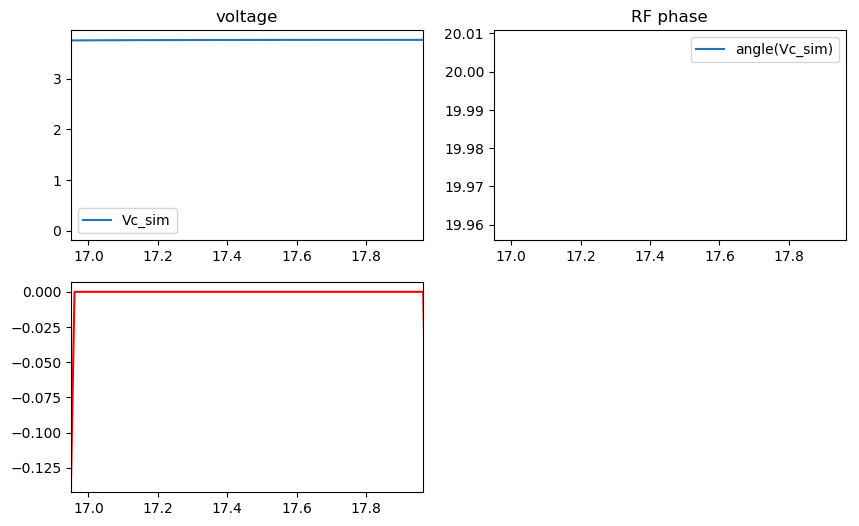

Vc_pp=0.01127627315238744, mean/setpoint=0.9419012868163703, Amplitude stability=2.9929551297517817e-9
phase_Vc_pp=0.05487005647313836, mean_phase_Vc=19.971186479994763, phase stability: 0.002747461024817027


In [1316]:
############################   plot #11111    ####################
fig=figure(figsize=(10,6))
subplot(221)
plot(Tsim*1e6,Vc_sim/1e6,label="Vc_sim")
#plot(Tsim*1e6,Vg/1e6+Vb/1e6,label="Vb+Vg")
Tplot_start=Nbeam_in+Nbeam_on;Nplot_end=(Nbeam_in+Nbeam_on+Nbeam_gap)
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6)
#ylim(real(set_Volt)/1e6*0.9,real(set_Volt)/1e6*1.05)
#ylim(minimum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6,maximum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6)
delta_Vc=maximum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6-minimum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6
mean_Vc=mean(real(Vc_sim[Tplot_start:Nplot_end]))
legend()
title("voltage")
subplot(222)
phase_Vc=180/pi*angle.(Vc_sim)
plot(Tsim,phase_Vc,label="angle(Vc_sim)")
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6)
ylim(minimum(phase_Vc[Tplot_start:Nplot_end]),maximum(phase_Vc[Tplot_start:Nplot_end]))
delta_phase_Vc=maximum(phase_Vc[Tplot_start:Nplot_end])-minimum(phase_Vc[Tplot_start:Nplot_end])
mean_phase_Vc=mean(phase_Vc[Tplot_start:Nplot_end])
title("RF phase")
legend()
println("Vc_pp=",delta_Vc, ", mean/setpoint=",mean_Vc/sp_ampl, ", Amplitude stability=",delta_Vc/mean_Vc)
println("phase_Vc_pp=",delta_phase_Vc,", mean_phase_Vc=",mean_phase_Vc,", phase stability: ",delta_phase_Vc/mean_phase_Vc)
subplot(223)
plot(Tsim*1e6,Ib,"r",label="Ib")
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6);

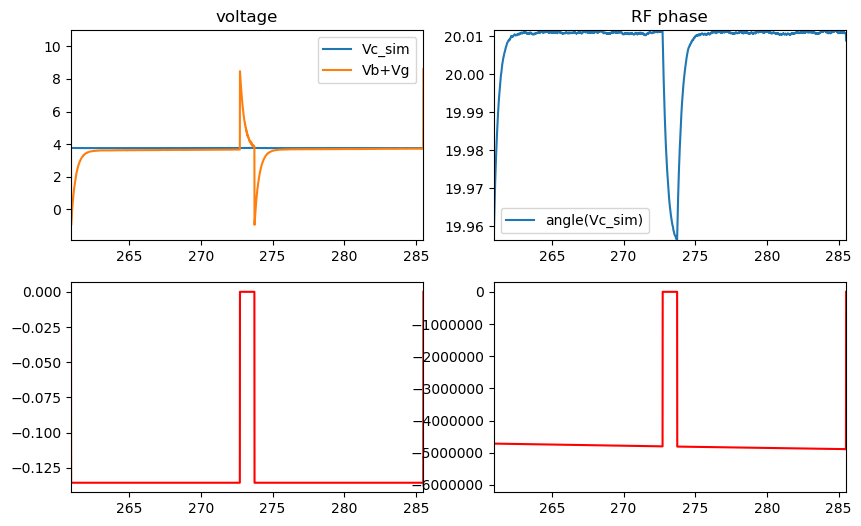

Vc_pp=0.01128955322544467, mean/setpoint=0.9400286049164097, Amplitude stability=3.0024493846249958e-9
phase_Vc_pp=0.05527428880757057, mean_phase_Vc=20.00788548544415, phase stability: 0.0027626252083351303


In [1328]:
############################   plot #2222    ####################
fig=figure(figsize=(10,6))
subplot(221)
plot(Tsim*1e6,Vc_sim/1e6,label="Vc_sim")
plot(Tsim*1e6,Vg/1e6+Vb/1e6,label="Vb+Vg")
Tplot_start=Nbeam_in+20*Nbucket;Nplot_end=(Nbeam_in+2Nbeam_on+Nbeam_gap+20*Nbucket)
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6)
#ylim(real(set_Volt)/1e6*0.99,real(set_Volt)/1e6*1.04)
#ylim(minimum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6,maximum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6)
delta_Vc=maximum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6-minimum(real(Vc_sim[Tplot_start:Nplot_end]))/1e6
mean_Vc=mean(real(Vc_sim[Tplot_start:Nplot_end]))
legend()
title("voltage")
subplot(222)
phase_Vc=180/pi*angle.(Vc_sim)
plot(Tsim*1e6,phase_Vc,label="angle(Vc_sim)")
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6)
ylim(minimum(phase_Vc[Tplot_start:Nplot_end]),maximum(phase_Vc[Tplot_start:Nplot_end]))
delta_phase_Vc=maximum(phase_Vc[Tplot_start:Nplot_end])-minimum(phase_Vc[Tplot_start:Nplot_end])
mean_phase_Vc=mean(phase_Vc[Tplot_start:Nplot_end])
title("RF phase")
legend()
subplot(223)
plot(Tsim*1e6,Ib,"r",label="Ib")
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6);
subplot(224)
plot(Tsim*1e6,Vb,"r",label="Vb")
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6);

println("Vc_pp=",delta_Vc, ", mean/setpoint=",mean_Vc/sp_ampl, ", Amplitude stability=",delta_Vc/mean_Vc)
println("phase_Vc_pp=",delta_phase_Vc,", mean_phase_Vc=",mean_phase_Vc,", phase stability: ",delta_phase_Vc/mean_phase_Vc)

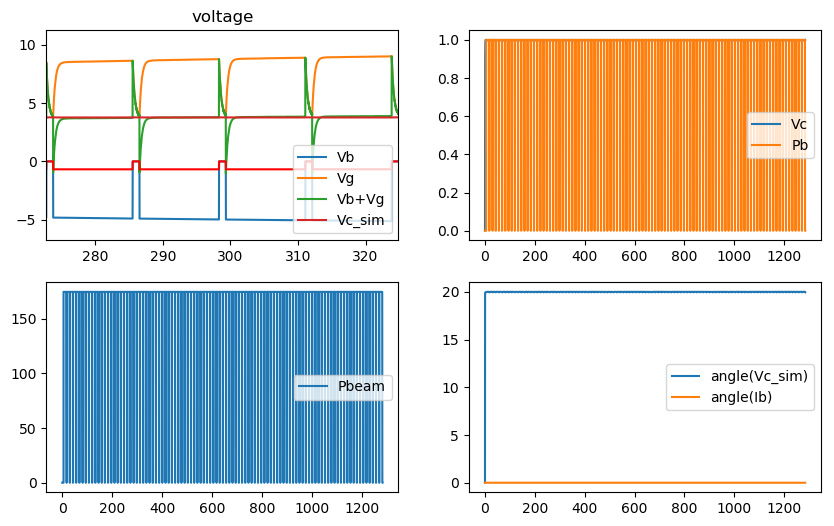

Pb_idea=-185379.98911012654, Pbeam =174389.94964177278 ,angleVC=0.34831313608484765


In [1318]:
############################   plot #11111    ####################
fig=figure(figsize=(10,6))
subplot(221)
plot(Tsim*1e6,Vb/1e6,label="Vb")
plot(Tsim*1e6,Vg/1e6,label="Vg")
plot(Tsim*1e6,Vg/1e6+Vb/1e6,label="Vb+Vg")
plot(Tsim*1e6,Vc_sim/1e6,label="Vc_sim")
Tplot_start=Nbeam_in+20*Nbucket+Nbeam_on;Nplot_end=(Nbeam_in+5Nbeam_on+5Nbeam_gap+20*Nbucket)
xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6)
#ylim(real(set_Volt)/1e6*0.9,real(set_Volt)/1e6*1.51)
#ylim(0,20)
plot(Tsim*1e6,Ib*5,"r-")
legend()
title("voltage")


subplot(222)
plot(Tsim*1e6,Vc_sim/maximum(real.(Vc_sim)),label="Vc")
plot(Tsim*1e6,Pbeam/maximum(real.(Pbeam)),label="Pb")

legend()

subplot(223)
#plot(Tsim, kly_Pref/1e3,label="Pref")

#plot(Tsim,kly_Pref2/1e3,label="Pref2")
plot(Tsim*1e6,Pbeam/1e3,label="Pbeam")
#plot(Tsim,kly_Pfor/1e3,label="Pklystron")
#Tplot_start=Tend-20Tfill;Nplot_start=Int(floor(Tplot_start/dt))
#xlim(Tplot_start*1e9,Tend)
legend()

subplot(224)
plot(Tsim*1e6,180/pi*angle.(Vc_sim),label="angle(Vc_sim)")
plot(Tsim*1e6,angle.(-Ib)*180/pi,label="angle(Ib)")
legend()
println("Pb_idea=",sp_ampl*sin(pi/180*sp_phase)*Ib0,", Pbeam =",maximum(real.(Pbeam))," ,angleVC=", angle(Vc_sim[Ntgrid-2*Nfall]))

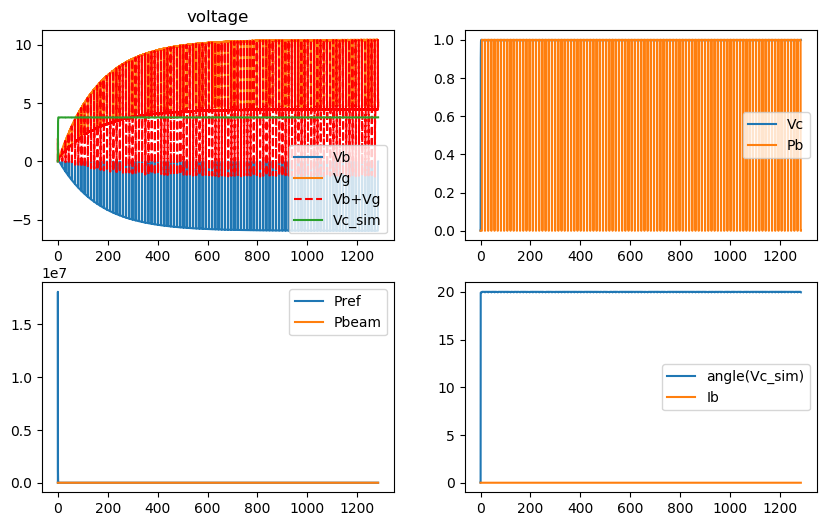

Pb_idea=-509327.3340988163, Pbeam =174389.94964177278 ,angleVC=0.34831313608484765


In [1319]:
############################   plot #222222     ####################
fig=figure(figsize=(10,6))
subplot(221)
plot(Tsim*1e6,Vb/1e6,label="Vb")
plot(Tsim*1e6,Vg/1e6,label="Vg")
plot(Tsim*1e6,Vg/1e6+Vb/1e6,"r--",label="Vb+Vg")
plot(Tsim*1e6,Vc_sim/1e6,label="Vc_sim")

#Tplot_start=Nbeam_in+20*Nbucket+Nbeam_on;Nplot_end=(Nbeam_in+2Nbeam_on+2Nbeam_gap+20*Nbucket)
#xlim(Tplot_start*dt*1e6,Nplot_end*dt*1e6)
#ylim(real(set_Volt)/1e6*0.99,real(set_Volt)/1e6*1.01)
legend()
title("voltage")


subplot(222)
plot(Tsim*1e6,Vc_sim/maximum(real.(Vc_sim)),label="Vc")
plot(Tsim*1e6,Pbeam/maximum(real.(Pbeam)),label="Pb")

legend()

subplot(223)
plot(Tsim*1e6, kly_Pref/1e3,label="Pref")

#plot(Tsim*1e6,kly_Pref2/1e3,label="Pref2")
plot(Tsim*1e6,Pbeam/1e3,label="Pbeam")
legend()

subplot(224)
plot(Tsim*1e6,180/pi*angle.(Vc_sim),label="angle(Vc_sim)")
plot(Tsim*1e6,angle.(-Ib)*180/pi,label="Ib")
legend()
println("Pb_idea=",sp_ampl*cos(pi/180*sp_phase)*Ib0,", Pbeam =",maximum(real.(Pbeam))," ,angleVC=", angle(Vc_sim[Ntgrid-2*Nfall]))

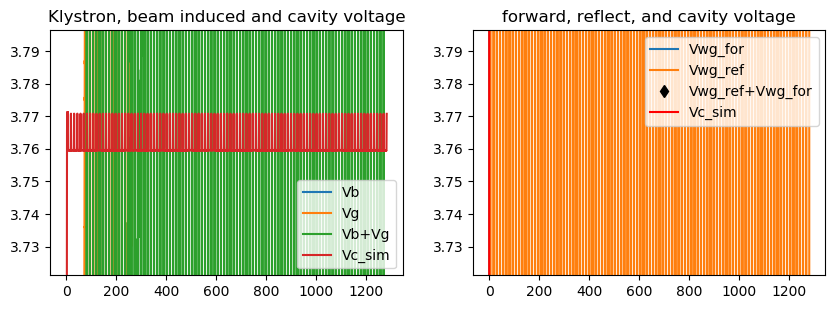

174389.94964177278

In [1320]:
############################   plot #111   ####################
fig=figure(figsize=(10,7))
subplot(221)

plot(Tsim*1e6,Vb/1e6,label="Vb")
plot(Tsim*1e6,Vg/1e6,label="Vg")
plot(Tsim*1e6,Vg/1e6+Vb/1e6,label="Vb+Vg")
plot(Tsim*1e6,Vc_sim/1e6,label="Vc_sim")
ylim(real(set_Volt)/1e6*0.99,real(set_Volt)/1e6*1.01)
legend()
title("Klystron, beam induced and cavity voltage")
subplot(222)
plot(Tsim*1e6,Vwg_for,label="Vwg_for")
plot(Tsim*1e6,Vwg_ref,label="Vwg_ref")
plot(Tsim*1e6,Vwg_ref+Vwg_for,"kd",label="Vwg_ref+Vwg_for")
plot(Tsim*1e6,Vc_sim/n_coupler,"r-",label="Vc_sim")
ylim(real(set_Volt)/1e6*0.99,real(set_Volt)/1e6*1.01)
title("forward, reflect, and cavity voltage")

legend()
maximum(real.(Pbeam))

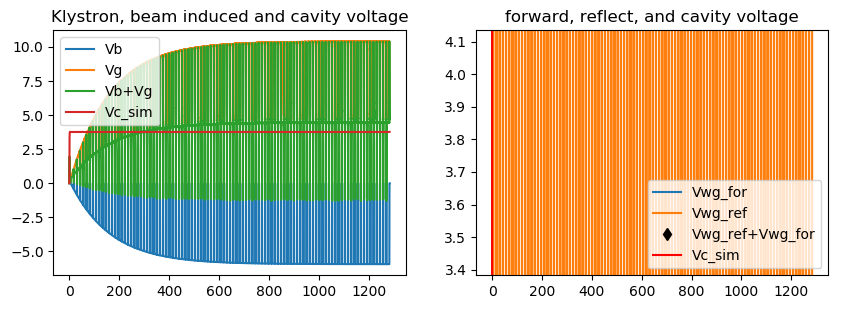

174389.94964177278

In [1321]:
############################   plot #222222      ####################
fig=figure(figsize=(10,7))
subplot(221)

plot(Tsim*1e6,Vb/1e6,label="Vb")
plot(Tsim*1e6,Vg/1e6,label="Vg")
plot(Tsim*1e6,Vg/1e6+Vb/1e6,label="Vb+Vg")
plot(Tsim*1e6,Vc_sim/1e6,label="Vc_sim")
legend()
title("Klystron, beam induced and cavity voltage")
subplot(222)
plot(Tsim*1e6,Vwg_for,label="Vwg_for")
plot(Tsim*1e6,Vwg_ref,label="Vwg_ref")
plot(Tsim*1e6,Vwg_ref+Vwg_for,"kd",label="Vwg_ref+Vwg_for")
plot(Tsim*1e6,Vc_sim/n_coupler,"r-",label="Vc_sim")
ylim(real(set_Volt)/1e6*0.9,real(set_Volt)/1e6*1.1)
title("forward, reflect, and cavity voltage")
legend()
maximum(real.(Pbeam))

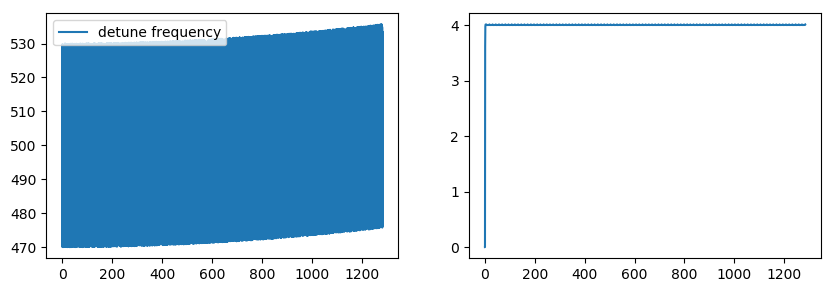

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000032EBAA0B8>

In [1322]:
############################   plot #11111   ####################
fig=figure(figsize=(10,7))
subplot(221)
plot(Tsim*1e6,detune_sim/2pi,label="detune frequency")  # fres=frf-detuneFre, lorentz detuning make the resonant freq smaller.
#xlim(0.01-0.001,0.01-0.0005)
legend()
subplot(222)
plot(Tsim*1e6,abs.(Vc_sim)/1e6)

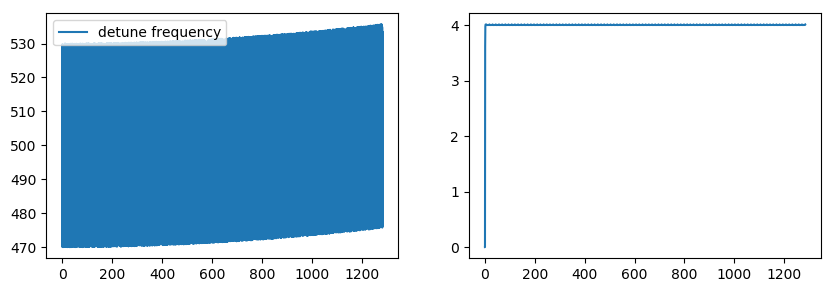

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000034F0E6F28>

In [1323]:
############################   plot #222222   ####################
fig=figure(figsize=(10,7))
subplot(221)
plot(Tsim*1e6,detune_sim/2pi,label="detune frequency")  # fres=frf-detuneFre, lorentz detuning make the resonant freq smaller.

legend()
subplot(222)
plot(Tsim*1e6,abs.(Vc_sim)/1e6)

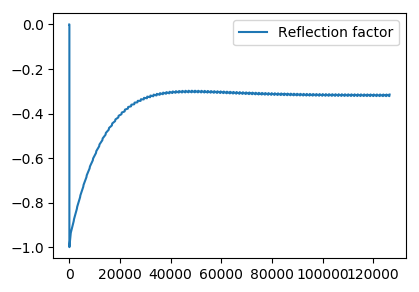

PyObject <matplotlib.legend.Legend object at 0x00000000EFE06470>

In [1231]:
fig=figure(figsize=(10,7))
subplot(221)
plot(Ref_wg,label="Reflection factor")
legend()


# Cavity field 

In [32]:
function RF_reflection(t,QL,beta_FPC,pulsewidth)
    Omegarf=2pi*frf
    f1(t,QL,beta_FPC,pulsewidth)=-(1-beta_FPC)/(1+beta_FPC)-2*beta_FPC/(1+beta_FPC)*exp(-Omegarf*t/2/QL)
    if t<0
        return 0
    elseif 0<=t<=pulsewidth
        return (f1(t,QL,beta_FPC,pulsewidth))
    elseif t>=pulsewidth
        return (f1(t,QL,beta_FPC,pulsewidth)-(f1(t-pulsewidth,QL,beta_FPC,pulsewidth)))
    end
    
end

function RF_filling(t,QL,beta_FPC,pulsewidth)
    Omegarf=2pi*frf
    if t<=0
        return 0
    elseif t<=pulsewidth
        return 1-exp(-Omegarf*t/2/QL)
    elseif t>=pulsewidth*0.9 
        return exp(-Omegarf*(t-pulsewidth)/2/QL)
    elseif t>=pulsewidth*1 
        return exp(-Omegarf*(t-pulsewidth)/2/QL)
    end
end
        
Ta=-0.002:dt:0; Tx=vcat(Ta,Tsim);
#fig=figure(figsize=(6,3))
#plot(Tx,map(t->RF_reflection(t,Q0/beta_coupler/5,beta_coupler,2Tfill),Tx),"r-")
#plot(Tx,map(t->RF_filling(t,Q0/beta_coupler/5,beta_coupler,2Tfill),Tx),"b--")


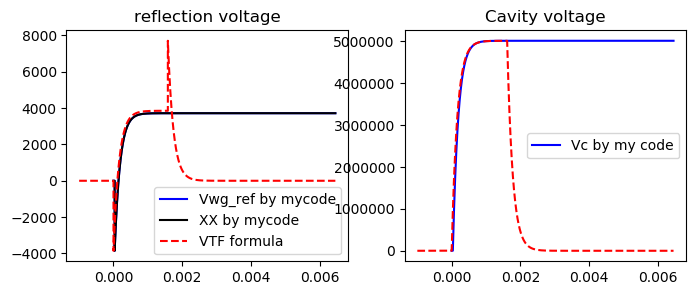

PyObject <matplotlib.legend.Legend object at 0x0000000046BD4198>

In [33]:
fig=figure(figsize=(8,3))
Ta=-0.001:dt:0; Tx=vcat(Ta,Tsim);
subplot(121)
plot(Tsim,(Vwg_ref),"b",label="Vwg_ref by mycode")
plot(Tsim,real.(Vwg_ref),"k-",label="XX by mycode")
a1=minimum(real.(Vwg_ref))
plot(Tx,map(t->-a1*RF_reflection(t,Q0/beta_coupler,beta_coupler,9.8Tfill),Tx),"r--",label="VTF formula")
legend()
title("reflection voltage")
subplot(122)
plot(Tsim,Vc_sim,"b",label="Vc by my code")
a2=maximum(real.(Vc_sim))
plot(Tx,map(t->a2*RF_filling(t,Q0/beta_coupler,beta_coupler,10Tfill),Tx),"r--")
title("Cavity voltage")
legend()

# RF power

In [34]:
# power calcuation
function Pg_power(Vsp_ampl,Vsp_phase,Ncavity,deltaf,beta,Ib0)
 currentfactor=1;
  # Crev=3833.845
 # frev=clight/Crev
 # RoQ=146*Ncavity;Q0=2.0e10;Vsp_phase=(pi/2-phase_sin);Qload=Q0/(1+beta);wo=2*pi*frev*315*24;w12=wo/(2Qload)
  a1=Vsp_ampl^2/4/RoQ/Q0*(beta+1)^2/beta;
  a2=(1+RoQ*Q0*abs(Ib0*currentfactor)*cos(Vsp_phase)/Vsp_ampl/(1+beta))^2;
  a3=(deltaf*currentfactor/(w12/2/pi)+RoQ*Q0*(Ib0*currentfactor)*sin(Vsp_phase)/Vsp_ampl/(1+beta))^2;
  Pg=a1*(a2+a3)/1e6;
  return Pg,a1,a2,a3
end
#Pg_power(11.1e6,3.010,5,4.81e4,2.5e10/4.29e4,2.496)

#case=(Vsp_ampl,phase_sin,Ncavity,deltaf,beta,Ib0)
case5GeV0=[11.1e6 3.010 5  4.81e4 2.5e10 4.29e4 2.496]  #1
case10GeV=[23.7e6 2.966 14 6.27e4 2.5e10 2.47e4 2.496]  #1
case18GeV=[68.1e6 2.541 12 1.64e3 2.5e10 2.62e5 0.261]  #3
case5GeV1=[11.1e6 3.010 5  4.81e4 2.5e10 2.47e4 2.496]   #4
case18GeV1=[68.1e6 2.541 12 1.64e3 2.5e10 2.47e4 0.261]  #5
paraset=[case5GeV0;case10GeV;case18GeV;case5GeV1;case18GeV1]
Pg=zeros(10);a1=zeros(10);a2=zeros(10);a3=zeros(10);
for i=1:5
caseNum=i
ax=(Pg_power(paraset[caseNum,1],paraset[caseNum,2],paraset[caseNum,3],paraset[caseNum,4],paraset[caseNum,5]/paraset[caseNum,6],paraset[caseNum,7]))
Pg[i]=ax[1]
a1[i]=ax[2]
a2[i]=ax[3]
a3[i]=ax[4]
    
end
[Pg a1 a2 a3]
#Pg_power(Vsp_ampl,Vsp_phase,Ncavity,deltaf,beta,Ib0)
Pg_power(sp_ampl,pi/180*sp_phase,1,deltaf,beta_coupler,Ib0)


(0.14936010220591167, 91325.57079680395, 1.6354685867579457, 0.0)

# S parameter

In [606]:
S11_cav=(beta_coupler-1+1im*(beta_coupler+1)*tanPsi)/(beta_coupler+1-1im*(beta_coupler+1)*tanPsi);S22_cav=S11_cav
S21_cav=1im*sqrt(abs(S11)^2);S12_cav=S21_cav
S_tuner=[1exp(1im) 2exp(2*1im);3 4]
Scav=[S11_cav S12_cav; S21_cav S22_cav];
lamda_rf=clight/frf
alpha_Tran=0.0001; beta_Tran=2pi/lamda_rf;
S_Tran(Lx)=[0 exp(-alpha_Tran*Lx-1im*beta_Tran*Lx);exp(-alpha_Tran*Lx-1im*beta_Tran*Lx) 0]
S_Tran(0.2)

2×2 Array{Complex{Float64},2}:
       0.0+0.0im       -0.787754-0.615958im
 -0.787754-0.615958im        0.0+0.0im     

# multiple reflection

In [36]:
Q0=1e9;beta_coupler=500000
S11=(beta_coupler-1+1im*(beta_coupler+1)*tanPsi)/(beta_coupler+1-1im*(beta_coupler+1)*tanPsi);S22=S11
S21=1im*sqrt(abs(S11)^2);S12=S21

alphaL=(Lcav*pi)/Q0/(clight/(frf-deltaf));
betaL=Lcav*2pi/(clight/(frf-deltaf));
deltaTcav=2*10/(frf-deltaf);
deltaPhi=deltaTcav*2pi*frf;
S11

0.9796037593163909 - 0.2009192781541732im

In [37]:
Ngrid=300000
a1=zeros(Complex,Ngrid);b1=zeros(Complex,Ngrid);a2=zeros(Complex,Ngrid);b2=zeros(Complex,Ngrid);
a1[1]=0; a2[1]=0;
b1[1]=S11*a1[1]; b2[1]=S21*a1[1]

for i=2:20000-1
  a1[i]=0;   a2[i]=exp(-2alphaL+1im*2betaL)*b2[i-1]
  b1[i]=a1[i]*S11+a2[i]*S12; b2[i]=S21*a1[i]+S22*a2[i]
end

a1[20000]=1182; a2[20000]=0;
b1[20000]=S11*a1[20000]; b2[20000]=S21*a1[20000]

for i=20001:Ngrid-50000
  a1[i]=a1[i-1]*exp(1im*deltaPhi);   a2[i]=exp(-2alphaL+1im*2betaL)*b2[i-1]
  b1[i]=a1[i]*S11+a2[i]*S12; b2[i]=S21*a1[i]+S22*a2[i]
end

for i=Ngrid-50000+1:Ngrid
  a1[i]=0;   a2[i]=exp(-2alphaL+1im*2betaL)*b2[i-1]
  b1[i]=a1[i]*S11+a2[i]*S12; b2[i]=S21*a1[i]+S22*a2[i]
end

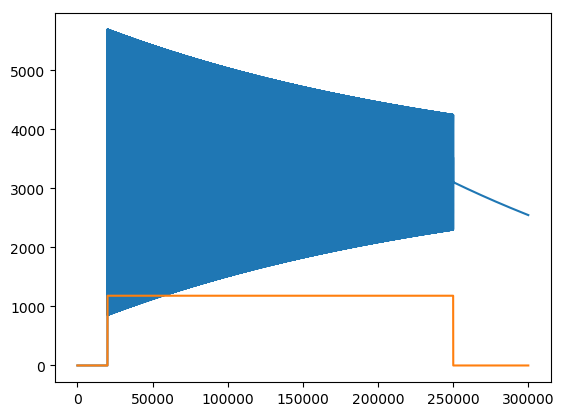

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000034B77710>

In [38]:
plot(abs.(b1))
plot(abs.(a1))

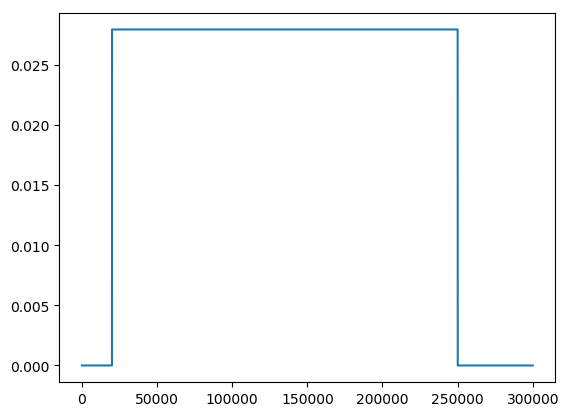

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004A4B29E8>

In [39]:
plot((a1.*conj(a1))/Z0/1e6)

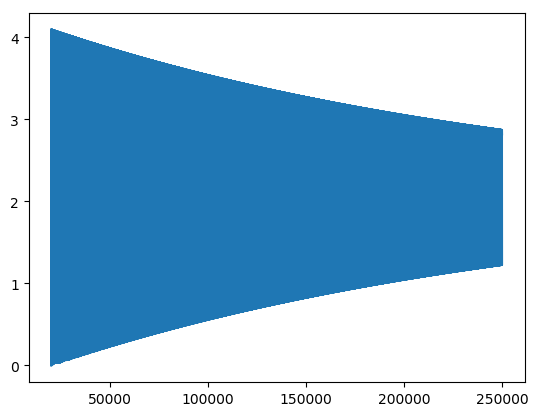

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004A707588>

In [40]:
plot(abs.(a2./a1))

In [41]:
Pg=Pg_power(2e6,0*pi/2,1,0,beta_coupler,0)[1]
sqrt(Pg*1e6*Z0)

13085.624235951473

In [42]:
Pg

3.424671232890411